# Практикум по анализу данных.

### Ссылка на датасет: https://www.kaggle.com/datasets/beaver68/cars-dataset-in-russia

### Данные представляют собой набор из 50+ характеристик автомобиля. Информация представлена более чем для 22 000 автомобилей из России на конец 2020 года.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
%load_ext rpy2.ipython

In [2]:
%%R
library(glue)

In [3]:
df = pd.read_csv('cars_dataset.csv', index_col = 0)

# Предобработка признаков

# предобработка Wheel_size

### Признак Wheel_size содержит в себе ширину шины (мм), высоту профиля (%) и диаметр обода (inch).

In [4]:
df.loc[24:34, ["Wheel_size"]]

Wheel_size
24              235/65/R17
25              235/65/R17
26              235/65/R17
27  235/60/R18  255/50/R19
28  235/60/R18  255/50/R19
29  275/50/R20  255/50/R19
30              255/50/R19
31  275/50/R20  255/50/R19
32  235/60/R18  255/50/R19
33  275/50/R20  255/50/R19
34              255/50/R19

### Есть автомобили, у которых есть несколько вариантов размера колеса. Разделим эти записи.

In [5]:
df.Wheel_size.fillna("0/0/R0", inplace=True)
def split_sizes(wheel_size):
    return wheel_size.strip().split("  ")
df['Wheel_size'] = df['Wheel_size'].apply(split_sizes)
df = df.explode('Wheel_size')

### Разделим этот признак на три, новые признака назовём tire_width, aspect_ratio, wheel_diametr. Пока заполним пропуски нулями.

In [6]:
df["Wheel_size"] = df["Wheel_size"].str.split("/R|/")

In [7]:
def get_tire_width(wheel_size):
    return int(wheel_size[0])
def get_aspect_ratio(wheel_size):
    return int(wheel_size[1])
def get_wheel_diametr(wheel_size):
    return int(wheel_size[2])

df["Tire_width"] = df.Wheel_size.apply(get_tire_width)
df["Aspect_ratio"] = df.Wheel_size.apply(get_aspect_ratio)
df["Wheel_diametr"] = df.Wheel_size.apply(get_wheel_diametr)

In [8]:
df.loc[24:34, ["Wheel_size", "Tire_width", "Aspect_ratio", "Wheel_diametr"]]

Wheel_size  Tire_width  Aspect_ratio  Wheel_diametr
24  [235, 65, 17]         235            65             17
25  [235, 65, 17]         235            65             17
26  [235, 65, 17]         235            65             17
27  [235, 60, 18]         235            60             18
27  [255, 50, 19]         255            50             19
28  [235, 60, 18]         235            60             18
28  [255, 50, 19]         255            50             19
29  [275, 50, 20]         275            50             20
29  [255, 50, 19]         255            50             19
30  [255, 50, 19]         255            50             19
31  [275, 50, 20]         275            50             20
31  [255, 50, 19]         255            50             19
32  [235, 60, 18]         235            60             18
32  [255, 50, 19]         255            50             19
33  [275, 50, 20]         275            50             20
33  [255, 50, 19]         255            50             19
34  [255, 50, 19]         255            50             19

### Удалим старый Wheel_size

In [9]:
df.drop("Wheel_size", axis=1, inplace=True)

### Предобработка year 

In [10]:
df.set_index(pd.Index(range(0, df.shape[0])), inplace=True)#в оригинальном датафрейме некоторые индексы пропущены
df['Year'] = df['Year'].astype('int64')
df['Release_start_series'] = df['Release_start_series'].astype('int64')
df['End_Serial'] = df['End_Serial'].astype('int64')
df[df.dtypes[df.dtypes == 'float64'].index] = df[df.dtypes[df.dtypes == 'float64'].index].astype('float64')
df['mark'] = df.mark.str.strip()

### Признак Volume имеет 88 объектов с нулевым значением. Все эти автомобили являются электрокарами. Создадим новый признак, который будет отвечать за то, что автомобиль является электрокарам.

In [11]:
df[df.Volume == 0].shape[0]

88

In [12]:
df.loc[df.Volume == 0, ["mark", "Model", "Country", "Volume"]].head()

mark     Model Country  Volume
7228       Smart  Forfour   German     0.0
7229       Smart  Forfour   German     0.0
7230       Smart  Forfour   German     0.0
7231       Smart  Forfour   German     0.0
7706  Volkswagen     Golf   German     0.0

In [13]:
df["Electric_car"] = 0
df.loc[df.Volume == 0, "Electric_car"] = 1

In [14]:
%%R -i df
df$Volume <- as.double(df$Volume)

# 1. Аппроксимация распределений данных с помощью ядерных оценок.

### Построим ядерные оценки плотности для:  
+ **объёма двигателя**    
+ **года выпуска**  
+ **пробега**  
+ **максимальной мощности**  
+ **длины и ширины автомобиля**

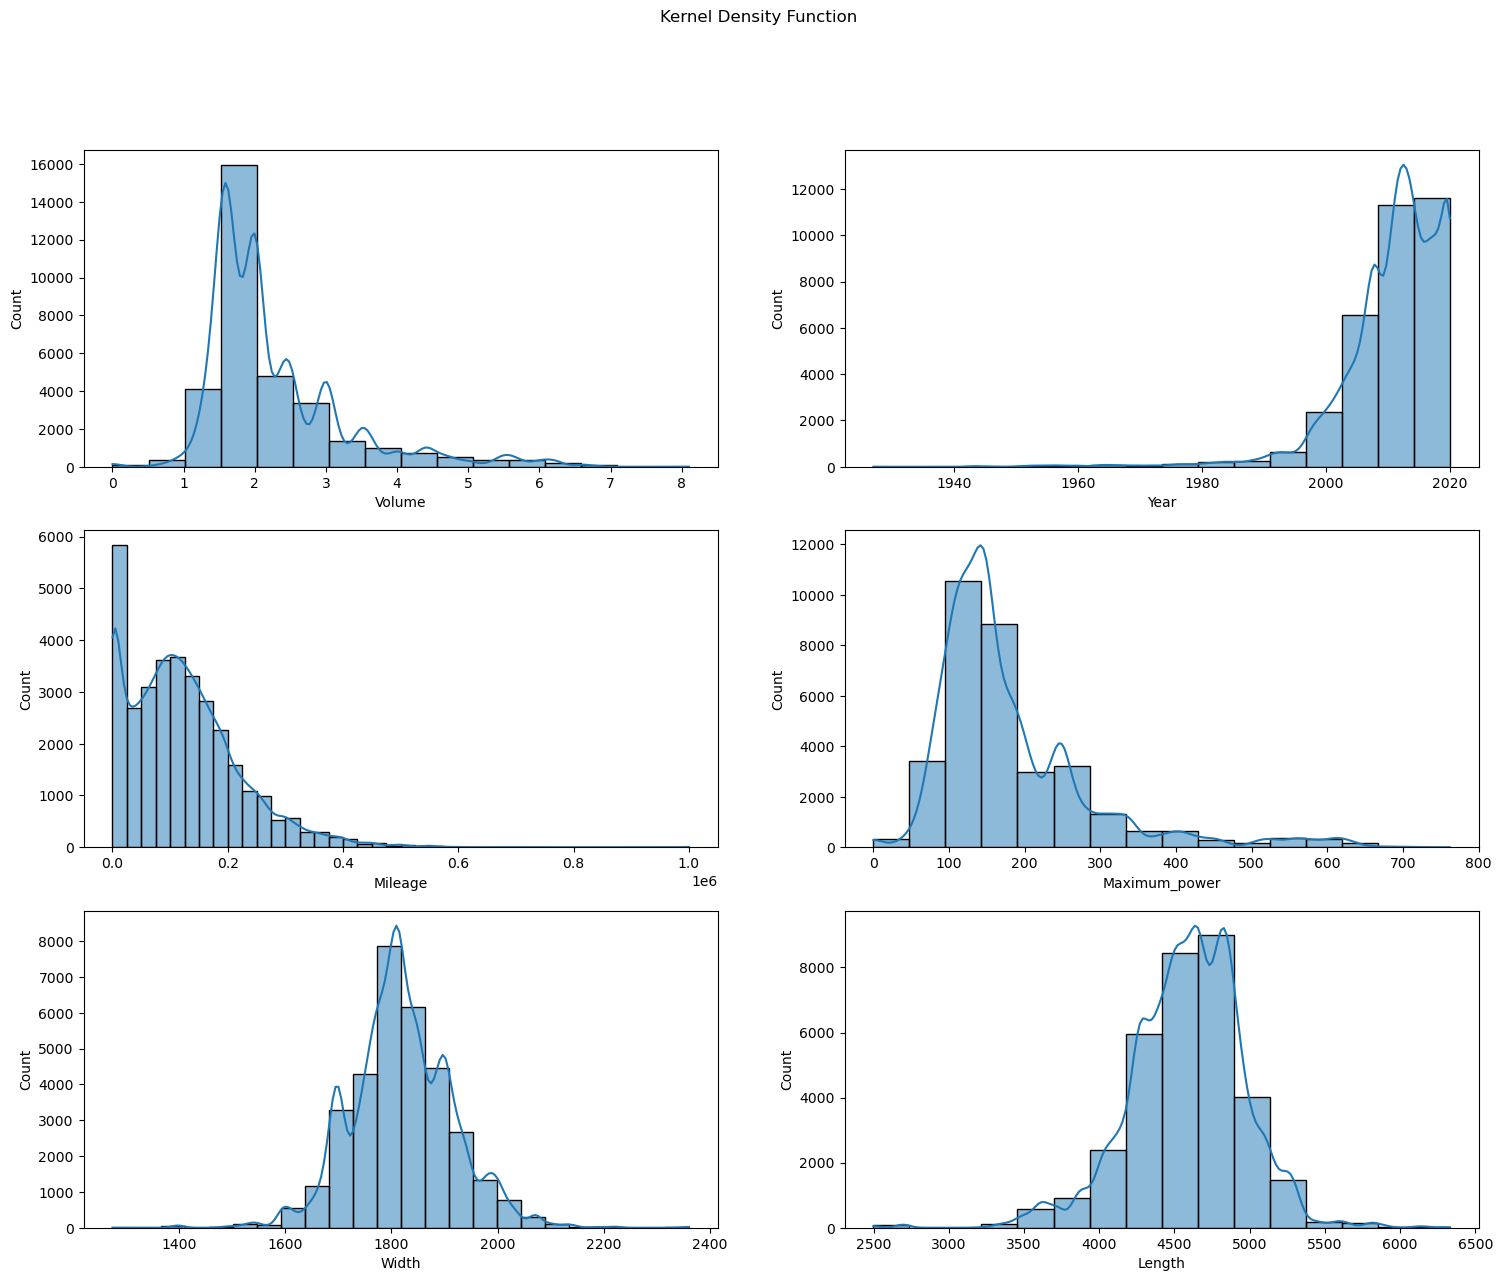

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

fig.suptitle('Kernel Density Function')

sns.histplot(ax=axes[0, 0], data = df, x='Volume', kde=True, bins = 16, common_norm=False)
sns.histplot(ax=axes[0, 1], data = df, x='Year', kde=True, bins = 16, common_norm=False)
sns.histplot(ax=axes[1, 0], data = df, x='Mileage', kde=True, bins = 40, common_norm=False)
sns.histplot(ax=axes[1, 1], data = df, x='Maximum_power', kde=True, bins = 16, common_norm=False)
sns.histplot(ax=axes[2, 0], data = df, x='Width', kde=True, bins = 24, common_norm=False)
sns.histplot(ax=axes[2, 1], data = df, x='Length', kde=True, bins = 16, common_norm=False);

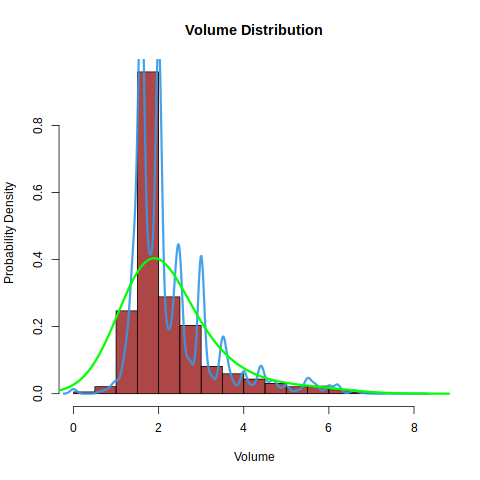

In [16]:
%%R
hist(df$Volume, breaks = 16, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Volume",
     ylab = "Probability Density",
     main = "Volume Distribution")
lines(density(df$Volume), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Volume, bw=0.7), col = "green", lwd = 3)

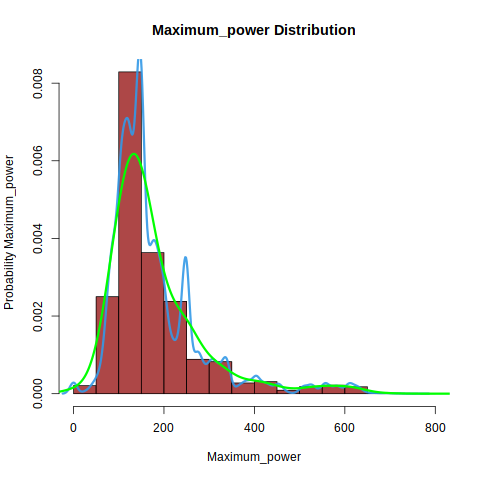

In [17]:
%%R
hist(df$Maximum_power, breaks = 12, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Maximum_power",
     ylab = "Probability Maximum_power",
     main = "Maximum_power Distribution")
lines(density(df$Maximum_power), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Maximum_power, bw=30.), col = "green", lwd = 3)

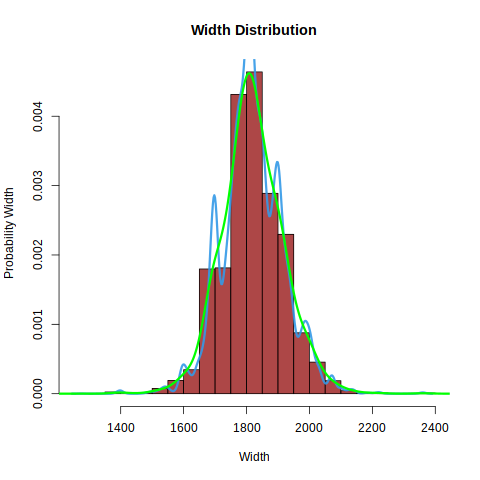

In [18]:
%%R
hist(df$Width, breaks = 16, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Width",
     ylab = "Probability Width",
     main = "Width Distribution")
lines(density(df$Width), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Width, bw=30.), col = "green", lwd = 3)

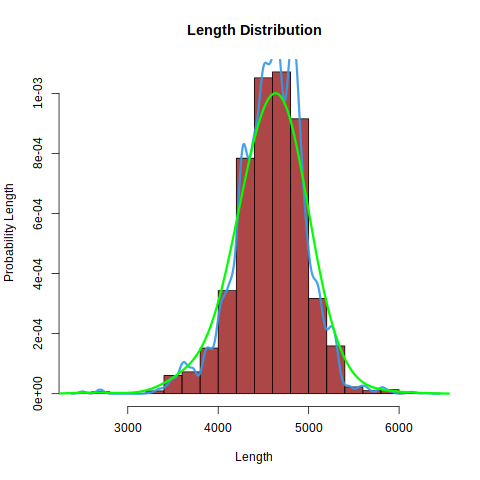

In [19]:
%%R
hist(df$Length, breaks = 24, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Length",
     ylab = "Probability Length",
     main = "Length Distribution")
lines(density(df$Length), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Length, bw=200.), col = "green", lwd = 3)

# 2. Анализ данных с помощью cdplot, dotchart, boxplot и stripchart.

### Построим график зависимости цены от пробега для автомобилей марки BMW

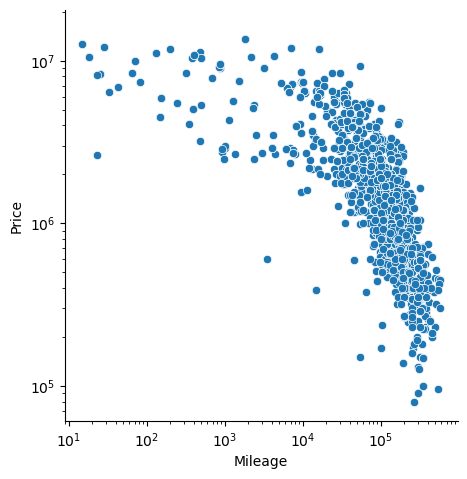

In [20]:
sns.relplot(x='Mileage',\
            y='Price',\
            data=df[df.mark == "BMW"])
plt.xscale('log')
plt.yscale('log')

### Видно, что цена на автомобили с меньшем пробегом выше.  
### Посмотрим как ведёт себя эта зависимость на разных типах коробки передач

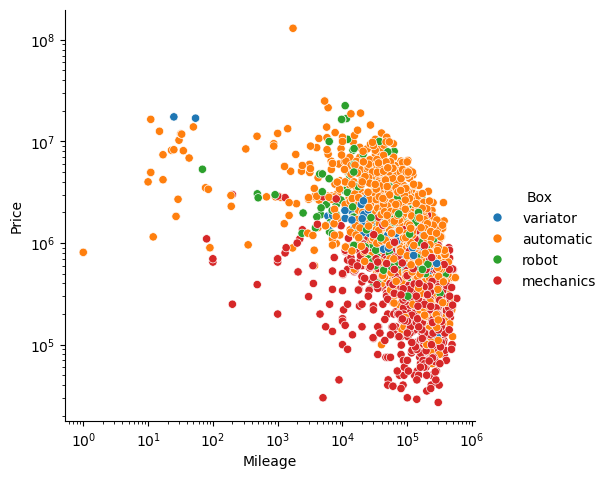

In [21]:
sns.relplot(x = 'Mileage',\
            y = 'Price',\
            data = df.sample(5000),
            hue = "Box")
plt.xscale('log')
plt.yscale('log')

### Заметим, что в среднем цена на автомобили с механической коробкой передач ниже чем на автомобили с автоматической коробкой.  Построим boxplot и убедимся в этом.

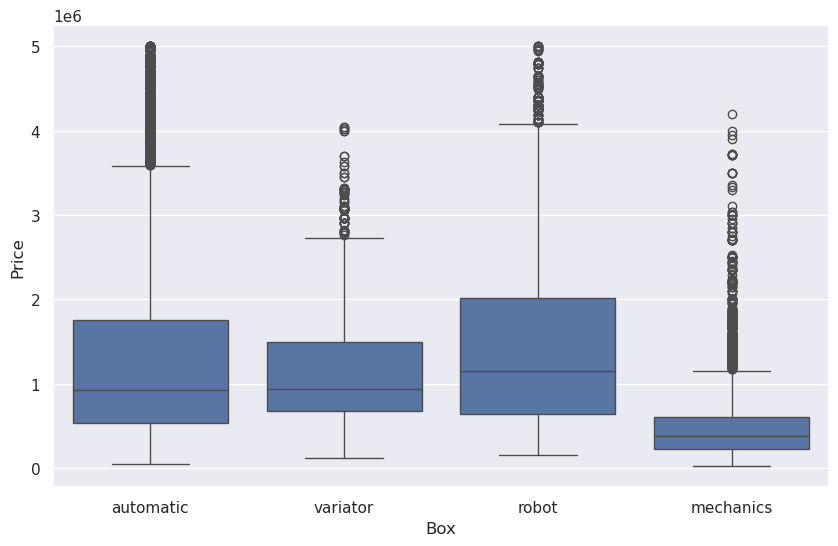

In [22]:
sns.set (rc={"figure.figsize":( 10 , 6 )})
sns.boxplot(x='Box', y='Price', data=df[df.Price < 5 * 10**6]);
#взяли только автомобили с ценой ниже 5 млн руб, чтобы получить качественный график

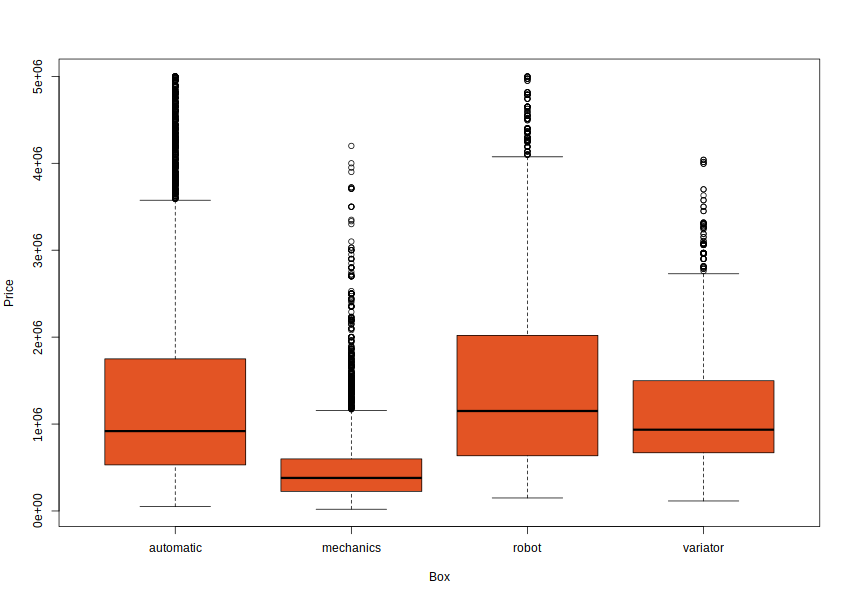

In [23]:
%%R -w 850 -h 600
data = subset(df, Price < 5 * 10**6, select = c('Box', "Price"))
boxplot(Price ~ Box, col = rgb(0.89, 0.33, 0.14, 1),  data = data)

### Пожалуй тремя самыми дорогими и попурными марками автомобилей в России считаются Mercedes, BMW и Audi. Возьмём 10 самых попурных марок автомобилей и построим boxplot цены. 

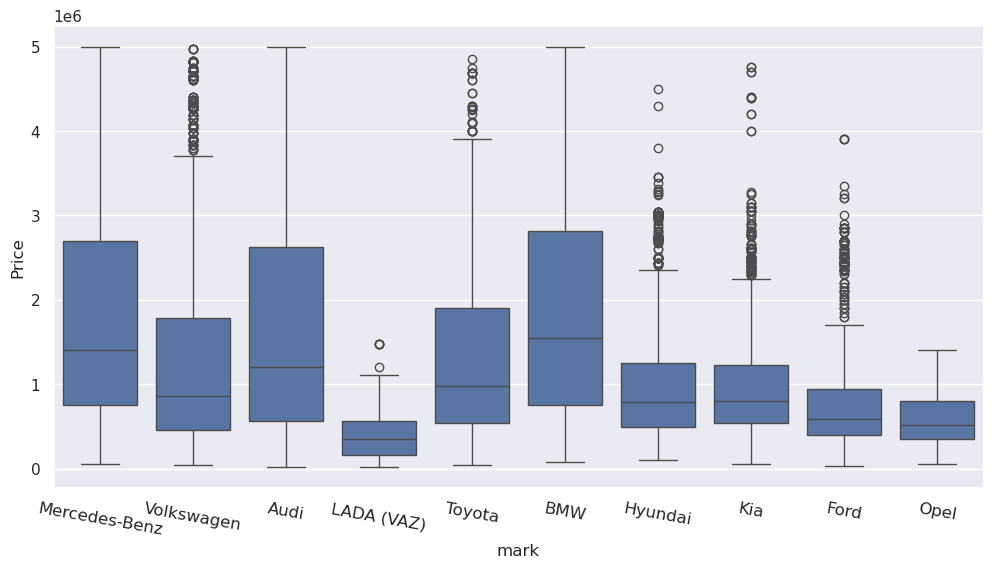

In [24]:
top_10_popular_marks = df.mark.value_counts().sort_values(ascending=False)[:10].index
mark_prices = df[df.mark.isin(top_10_popular_marks) & (df.Price < 5 * 10**6)]
sns.set (rc={"figure.figsize":( 12 , 6 )})
sns.boxplot(x='mark', y='Price', data=mark_prices)
plt.tick_params(axis='x', which='major', labelsize=12, rotation=-10)

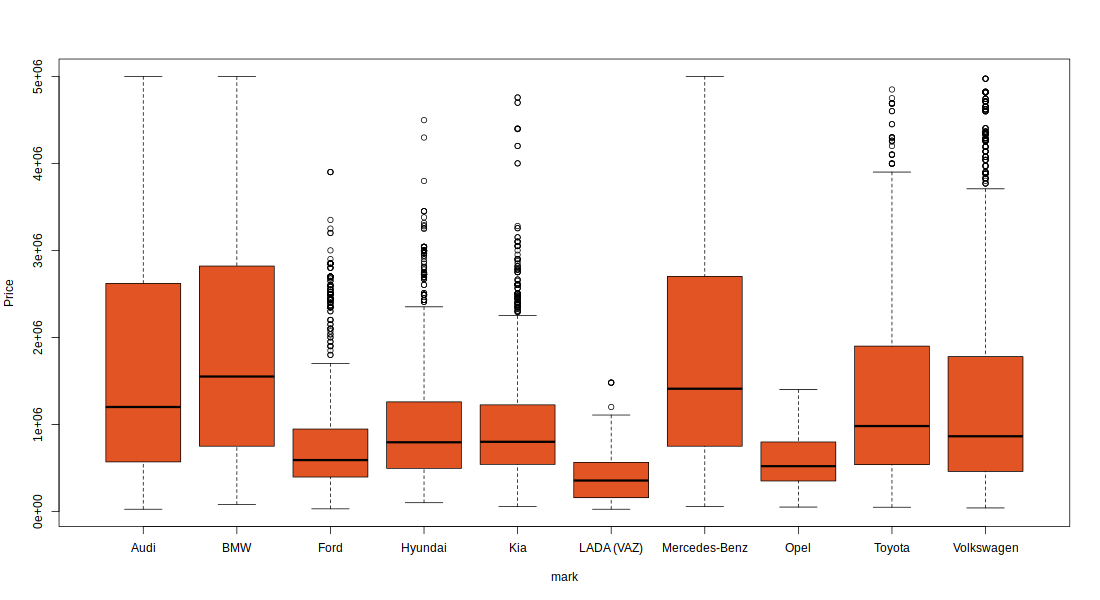

In [25]:
%%R -i mark_prices -w 1100 -h 600
library(repr)
boxplot(Price ~ mark, col = rgb(0.89, 0.33, 0.14, 1),  data = mark_prices)

### Также построим boxplot цены для 10 самых популярных стран производителей.

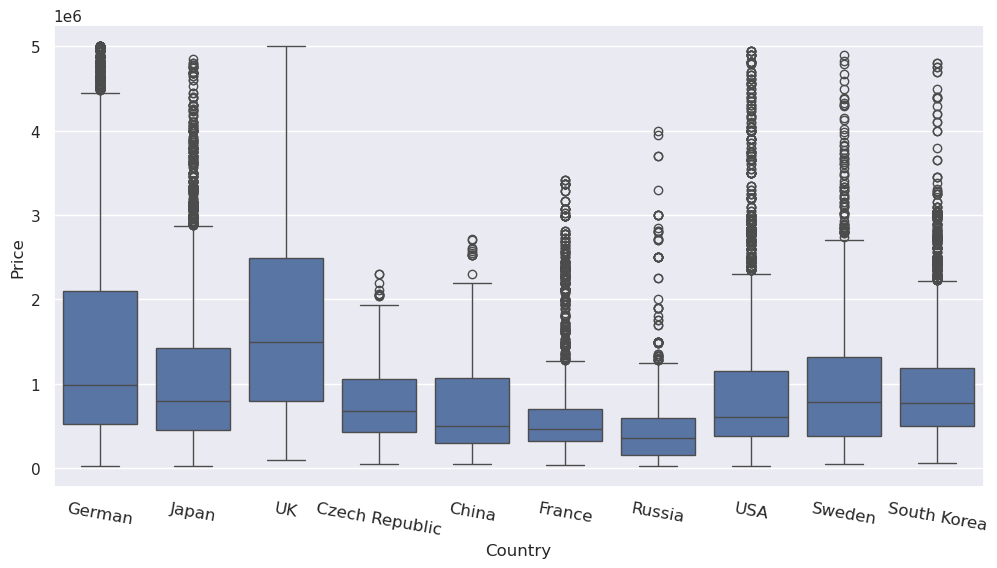

In [26]:
top_10_popular_countries = df.Country.value_counts().sort_values(ascending=False)[:10].index
country_prices = df[df.Country.isin(top_10_popular_countries) & (df.Price < 5 * 10**6)]
sns.set (rc={"figure.figsize":( 12 , 6 )})
sns.boxplot(x='Country', y='Price', data=country_prices)
plt.tick_params(axis='x', which='major', labelsize=12, rotation=-10)

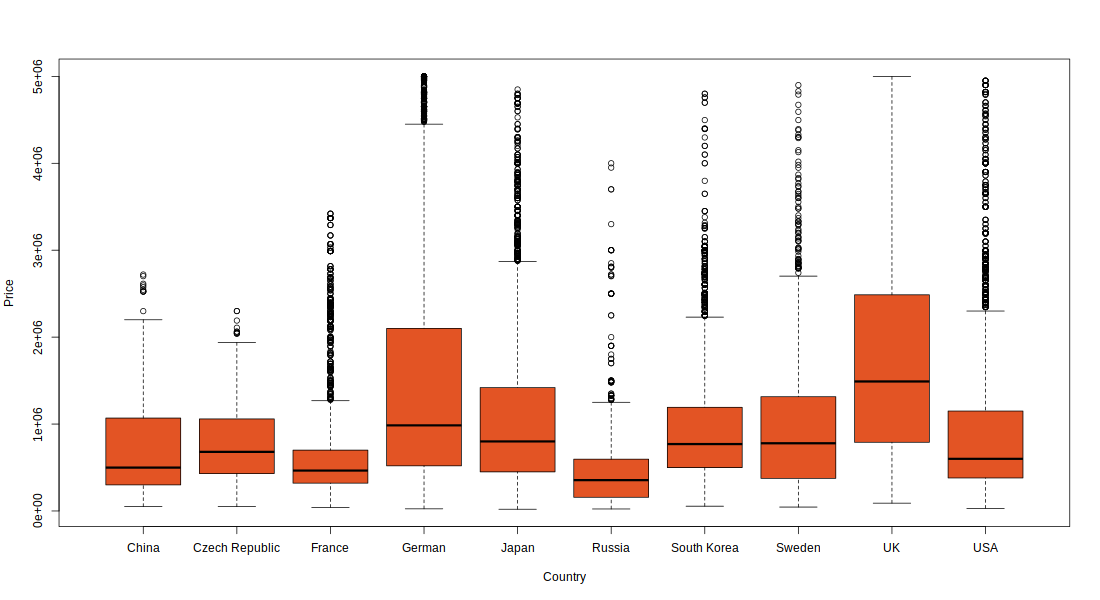

In [27]:
%%R -i country_prices -w 1100 -h 600
library(repr)
boxplot(Price ~ Country, col = rgb(0.89, 0.33, 0.14, 1),  data = country_prices)

### Очевидно, что на рынке больше ценнятся новые автомобли. Можем заметить, что зависимость цены от года выпуска экспоненциальная.

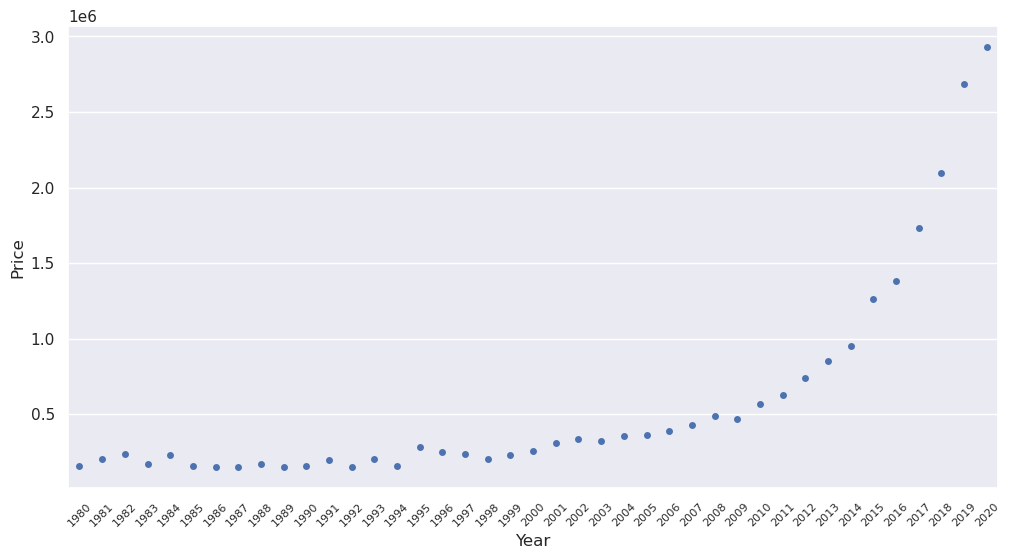

In [28]:
med_price_per_year = df.loc[df.Year >=1980, ['Year', 'Price']].groupby('Year', as_index=False).median()
sns.stripplot(x='Year', y='Price', data=med_price_per_year)
plt.tick_params(axis='x', which='major', labelsize=8, rotation=45)

plt.show()

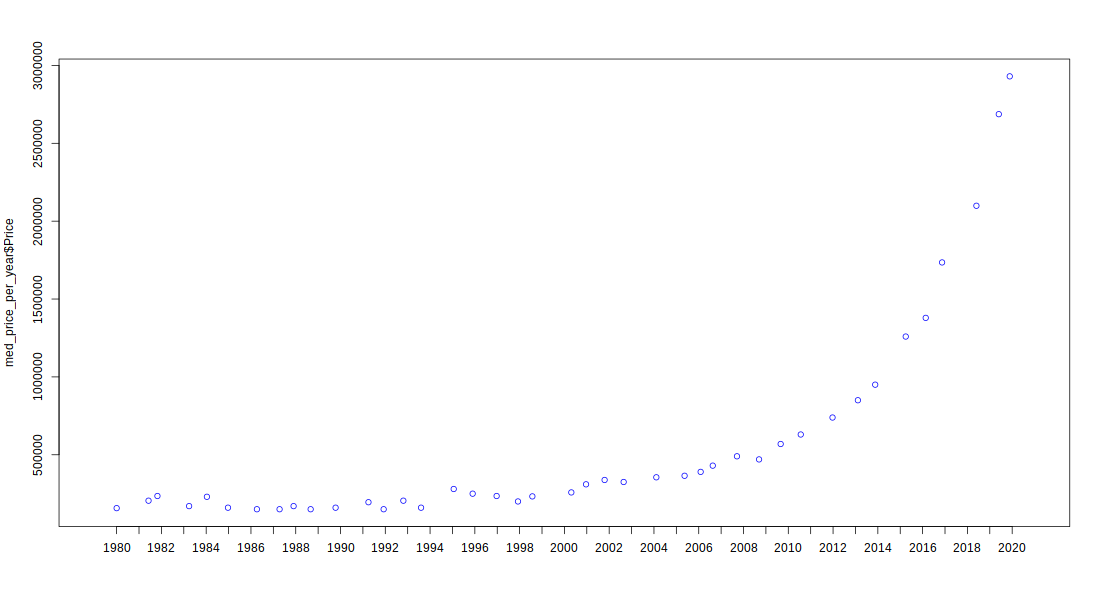

In [29]:
%%R -i med_price_per_year -w 1100 -h 600
stripchart(med_price_per_year$Price ~ med_price_per_year$Year,
           method = "jitter",
           jitter = 0.45,
           pch = 1, col = 'blue', vertical = TRUE)

### Мощность автомобиля увеличивается при увеличении количества цилиндров двигалеля 

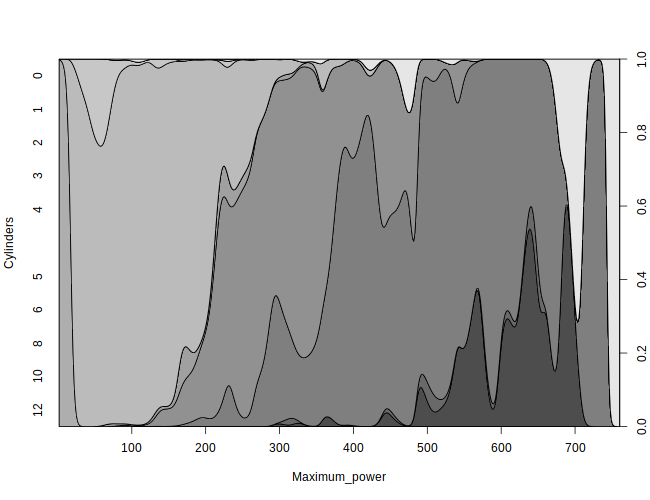

In [30]:
%%R -w 650 -h 500
df$Cylinders <- as.factor(df$Cylinders)
cdplot(Cylinders ~ Maximum_power, data=df)

### Кроме того у более тяжёлых машин (класс которых выше) мощность тоже должна быть больше. Что мы и наблюдаем ниже.

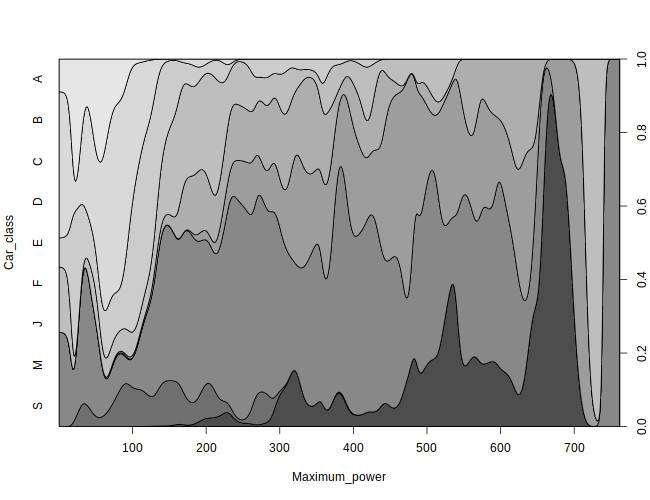

In [31]:
%%R -w 650 -h 500
df$Car_class <- as.factor(df$Car_class)
cdplot(Car_class ~ Maximum_power, data=df)

### Убедимся в этом ещё раз построив график медианной максимальной мощности от типа класса

In [32]:
med_mp_per_class = df.groupby("Car_class", as_index = False)['Maximum_power'].median().rename(\
            columns={"Maximum_power" : "Median_Maximum_power"}).sort_values("Median_Maximum_power")

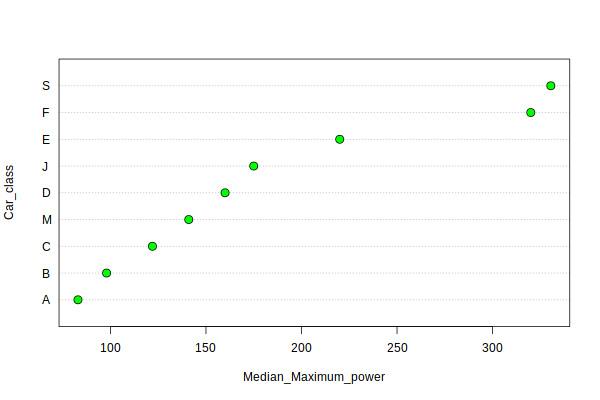

In [33]:
%%R -i med_mp_per_class -w 600 -h 400
dotchart(med_mp_per_class$Median_Maximum_power, labels = unique(med_mp_per_class$Car_class),
         pch = 21, bg = "green", pt.cex = 1.5, xlab = "Median_Maximum_power", ylab = "Car_class")

## 3. Проверка, являются ли наблюдения выбросами с точки зрения формальных статистических критериев Граббса и Q-теста Диксона. Визуализация результатов.

### Проведём тест Граббса на данных о цене автомобиля

In [93]:
from outliers import smirnov_grubbs as grubbs

len(grubbs.max_test_indices(np.array(df.Price), alpha=0.01))

892

### При уровне значимости в 1 процент тест выдаёт 728 выбросов. Посмотрим на некоторые из них.

In [94]:
df.loc[list(grubbs.max_test_indices(np.array(df.Price), alpha=0.01)),\
       ['Price', 'mark', 'Model', 'Year', 'Mileage']].sort_values("Price", ascending=False).head(10)

Price           mark       Model  Year  Mileage
27311  130000000.0        Maybach         62   2009   1724.0
27512  130000000.0        Maybach         62   2009   1724.0
18513   57000000.0    Rolls-Royce    Phantom   2020    500.0
32899   52500000.0  Mercedes-Benz       W188   1952  12000.0
18512   51200000.0    Rolls-Royce    Phantom   2020      0.0
31046   33215000.0        Ferrari  GTC4Lusso   2020      0.0
31047   33215000.0        Ferrari  GTC4Lusso   2020      0.0
4173    31800000.0    Rolls-Royce     Wraith   2020      0.0
4174    31800000.0    Rolls-Royce     Wraith   2020      0.0
31050   29531000.0        Ferrari  GTC4Lusso   2020      0.0

In [95]:
%%R
library(outliers)
grubbs.test(df$Price)


	Grubbs test for one outlier

data:  df$Price
G = 51.08058, U = 0.92156, p-value < 2.2e-16
alternative hypothesis: highest value 1.3e+08 is an outlier



In [96]:
%%R
subset(df[, c('Price', 'mark', 'Model', 'Year')], df$Price == 1.3*10**8)

        Price    mark Model Year
27311 1.3e+08 Maybach   62  2009
27512 1.3e+08 Maybach   62  2009


### Видим,  что с точки зрения цены тест считает выбросами Maybach, Rolls-Royce и Ferrari.

### Проведём тот же тест для максимальной скорости

In [97]:
grubbs.max_test_indices(np.array(df.Maximum_speed), alpha=.05),\
grubbs.max_test_indices(np.array(df.Maximum_speed), alpha=.1)

([], [29721, 29722, 29723, 29724])

In [98]:
df.loc[list(grubbs.max_test_indices(np.array(df.Maximum_speed), alpha=.1)),\
       ['Maximum_speed', 'mark', 'Model', 'Year']]

Maximum_speed     mark  Model  Year
29721          341.0  McLaren  720S   2018
29722          341.0  McLaren  720S   2018
29723          341.0  McLaren  720S   2017
29724          341.0  McLaren  720S   2017

In [99]:
%%R
grubbs.test(df$Maximum_speed)


	Grubbs test for one outlier

data:  df$Maximum_speed
G = 4.54803, U = 0.99938, p-value = 0.08978
alternative hypothesis: highest value 341 is an outlier



In [100]:
%%R
subset(df[, c('Maximum_speed', 'mark', 'Model', 'Year')], df$Maximum_speed == 341)

      Maximum_speed    mark Model Year
29721           341 McLaren 720S  2018
29722           341 McLaren 720S  2018
29723           341 McLaren 720S  2017
29724           341 McLaren 720S  2017


### Видим, что McLaren является выбросом.

### Проведём тест Граббса для максимальной мощности автомобилей

In [101]:
np.array(grubbs.max_test_indices(np.array(df.Maximum_power), alpha=.05)).reshape(1, -1)

array([[27808, 29721, 29722, 29723, 29724, 29705, 29842, 29843, 29851,
        29852, 29890, 29891, 31046, 31047, 31048, 31049, 31050, 31051,
        15569, 15570, 31873, 31874, 31875, 31876, 31877, 31878, 31879,
        31880]])

In [102]:
df.loc[list(grubbs.max_test_indices(np.array(df.Maximum_power), alpha=.05)),\
      ['Maximum_power', 'mark', 'Model', 'Year']].sort_values('Maximum_power', ascending=False).head(10)

Maximum_power     mark        Model  Year
27808          762.0    Tesla     Model X   2016
29722          720.0  McLaren        720S   2018
29723          720.0  McLaren        720S   2017
29724          720.0  McLaren        720S   2017
29721          720.0  McLaren        720S   2018
29705          717.0    Dodge  Challenger   2020
29842          700.0    Tesla     Model S   2015
29843          700.0    Tesla     Model S   2015
29851          700.0    Tesla     Model S   2015
29852          700.0    Tesla     Model S   2015

In [103]:
%%R
grubbs.test(df$Maximum_power)


	Grubbs test for one outlier

data:  df$Maximum_power
G = 5.54110, U = 0.99908, p-value = 0.0004964
alternative hypothesis: highest value 762 is an outlier



In [104]:
%%R
subset(df[, c('Maximum_power', 'mark', 'Model', 'Year')], Maximum_power == 762)

      Maximum_power  mark    Model Year
27808           762 Tesla Model X  2016


### Тест посчитал Tesla Model X 2016 года с 762 л.с. выбросом, что справедливо. Также выбросом считается McLaren 720 S

## Q-Тест Диксона

### Тест Диксона находит выброс в выборке размера не больше 30. Проведём этот тест для максимальной мощности на срезе, который содержит Tesla Model X.

In [105]:
%%R
dixon.test(df$Maximum_power[18100:18120])


	Dixon test for outliers

data:  df$Maximum_power[18100:18120]
Q = 0, p-value < 2.2e-16
alternative hypothesis: lowest value 0 is an outlier



### Тоже самое проделаем с ценой и увидим  Maybach за 130 млн. р.

In [106]:
%%R
dixon.test(df$Price[17710:17730])


	Dixon test for outliers

data:  df$Price[17710:17730]
Q = 0.024213, p-value < 2.2e-16
alternative hypothesis: highest value 1300000 is an outlier



# 4. Воспользоваться инструментами для заполнения пропусков в данных. Пропуски внести вручную и сравнить результаты заполнения с истинными значениями. 

### Создадим копию датафрейма и возьмём 1000 случайных объектов, которые будем заполнять пропусками

In [107]:
df_copy = df.copy()
indexes_with_gaps = df_copy.sample(1000).index

In [108]:
%R -i df_copy -i indexes_with_gaps

### Добавим пропуски и проверим, что они появились

In [109]:
df_copy.loc[indexes_with_gaps, "Volume"] = np.nan
df.Volume.isna().sum(), df_copy.Volume.isna().sum()

(0, 1000)

In [110]:
%%R
df_copy[indexes_with_gaps, c("Volume")] <- NA
print(c(sum(is.na(df[indexes_with_gaps, c("Volume")])), sum(is.na(df_copy[indexes_with_gaps, c("Volume")]))))

[1]    0 1000


### Качество заполнения будем оценивать по метрике MSE. Для начала заполним все пропуски нулями и посмотрим на mse.

In [111]:
from sklearn.metrics import mean_squared_error as mse

In [112]:
df_copy.Volume.fillna(0, inplace=True)
mse_with_fill_zeros = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values,\
                          df.loc[indexes_with_gaps, 'Volume'].values)
print(f"{mse_with_fill_zeros=}")

mse_with_fill_zeros=6.05006


In [113]:
%%R
library("Metrics")
df_copy[, c("Volume")][is.na(df_copy[, c("Volume")])] <- 0
mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

[1] 6.00715


### Заполним проски средним значением, медианой и модой, посмотрим на MSE.

In [114]:
df_copy.loc[indexes_with_gaps, "Volume"] = np.nan
mean = df_copy.Volume.mean()
median = df_copy.Volume.median()
mode = df_copy.Volume.mode()[0]

In [115]:
df_copy.loc[indexes_with_gaps, "Volume"] = mean
mse_for_mean = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values, df.loc[indexes_with_gaps, 'Volume'].values)

df_copy.loc[indexes_with_gaps, "Volume"] = median
mse_for_median = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values, df.loc[indexes_with_gaps, 'Volume'].values)

df_copy.loc[indexes_with_gaps, "Volume"] = mode
mse_for_mode = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values, df.loc[indexes_with_gaps, 'Volume'].values)

print(f"{mse_for_mean = }\n{mse_for_median = }\n{mse_for_mode = }")

mse_for_mean = 0.9611363814756869
mse_for_median = 1.02606
mse_for_mode = 1.39086


In [116]:
%%R
df_copy[indexes_with_gaps, c("Volume")] <- NA
mean <- mean(df_copy$Volume, na.rm=TRUE)
median <- median(df_copy$Volume, na.rm=TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
mode <- getmode(df_copy$Volume)

In [117]:
%%R
df_copy[indexes_with_gaps, c("Volume")] <- mean
mse_for_mean <- mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

df_copy[indexes_with_gaps, c("Volume")] <- median
mse_for_median <- mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

df_copy[indexes_with_gaps, c("Volume")] <- mode
mse_for_mode <- mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

print(glue("mse_for_mean = {mse_for_mean}\n mse_for_median = {mse_for_median}\n mse_for_mode = {mse_for_mode}"))

mse_for_mean = 0.942412191104442
mse_for_median = 1.00435
mse_for_mode = 1.36491


# 5. Сгенерировать данные из нормального распределения с различными параметрами и провести анализ с помощью:  
- **графиков эмпирических функций распределений**  
- **квантилей**  
- **метода огибающих**  
- **стандартных процедур проверки гипотез о нормальности (критерии Колмогорова-Смирнова, ШапироУилка, Андерсона-Дарлинга, Крамера фон Мизеса, Колмогорова-Смирнова в модификации Лиллиефорса и Шапиро-Франсия)**

### Сгенерируем выборки $N(0, 1), N(2000, 10000), N(5000, 16000)$ объёмами 50 и 1000

In [118]:
np.random.seed(2326)

sizes = [50, 1000]
locs = [0, 2000, 5000]
scales = [1, 100, 400]
samples_small = np.zeros((3, 50), 'float64')
samples_big = np.zeros((3, 1000), 'float64')

for i in range(len(locs)):
    samples_big[i] = norm.rvs(locs[i], scales[i], sizes[1])
    samples_small[i] = norm.rvs(locs[i], scales[i], sizes[0])

In [119]:
%%R
set.seed(2326)

sample1 <- rnorm(50, 0, 1)
sample2 <- rnorm(50, 2000, 100)
sample3 <- rnorm(50, 5000, 400)
sample4 <- rnorm(1000, 0, 1)
sample5 <- rnorm(1000, 2000, 100)
sample6 <- rnorm(1000, 5000, 400)

### Эмпирические функции распределния

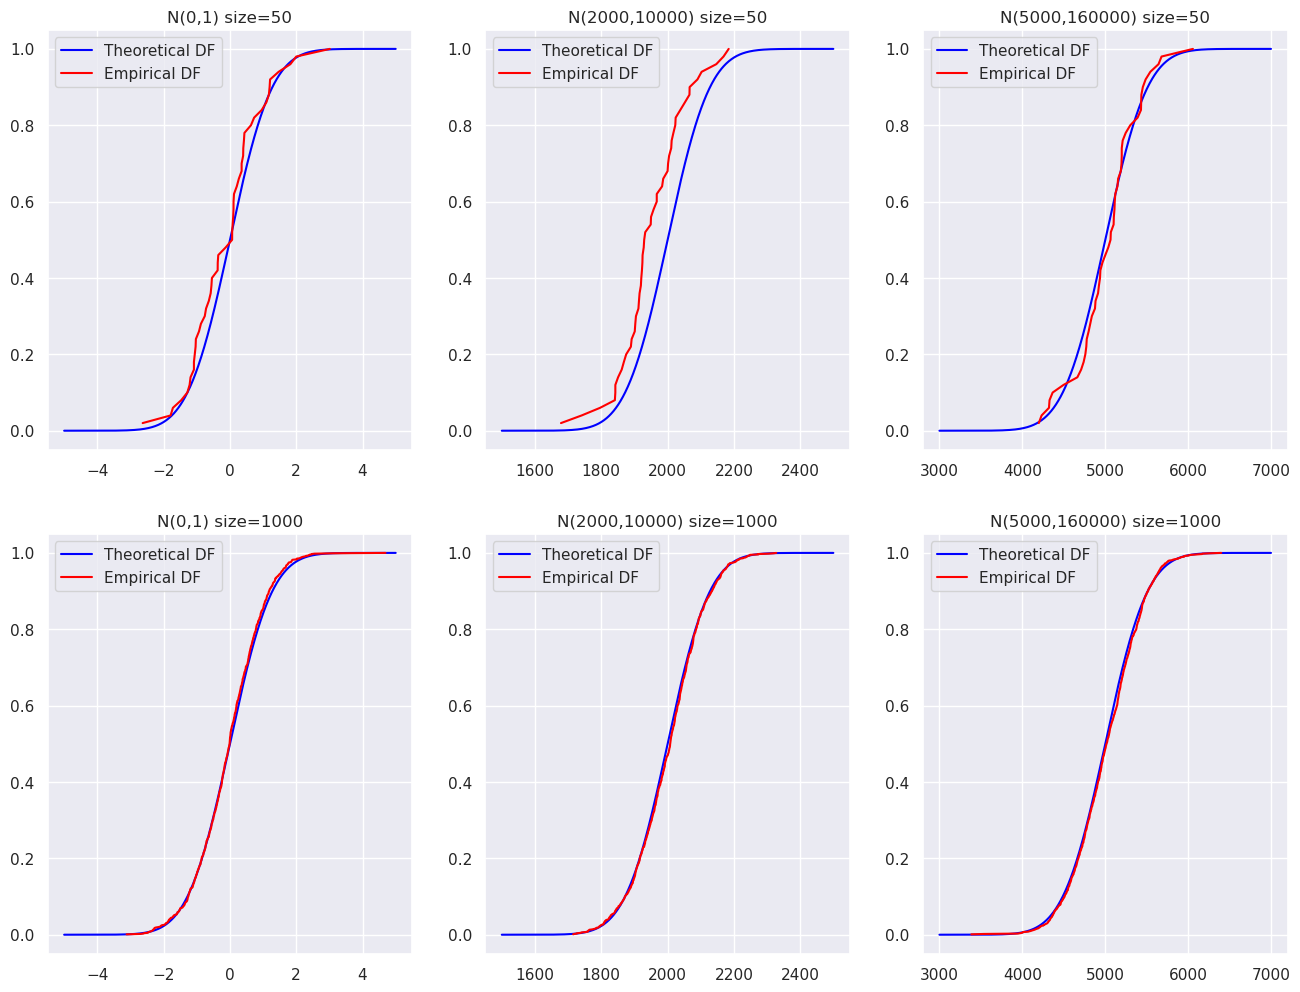

In [120]:
from statsmodels.distributions.empirical_distribution import ECDF
sns.set_style("darkgrid")
f, axes = plt.subplots(2,3, figsize=(16, 12))

for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        
        #Theoretical DF
        x_theor = np.linspace(locs[i] - 5 * scales[i],\
                              locs[i] + 5 * scales[i],\
                              num=1000)
        y_theor = norm.cdf(x_theor, locs[i], scales[i])
        sns.lineplot(x=x_theor, y=y_theor, color="blue", label='Theoretical DF', ax=axes[j, i])
        
        #Empirical DF
        ecdf = ECDF(sample)
        sns.lineplot(x=ecdf.x, y=ecdf.y, color="red", label="Empirical DF", ax=axes[j, i])
        
        plt.legend
        axes[j, i].title.set_text(f"N({locs[i]},{scales[i]**2}) size={sizes[j]}")

In [121]:
%%R
graph_distr_fun <- function(sample, mean, scale, size){
    #Empirical DF
    plot(sort(sample), (1:size)/size, type="S", col="blue", ylab="", xlab="",
        main=glue("N({mean}, {scale**2}) size={size}"))

    #Theoretical DF
    x = seq(mean - 5*scale, mean + 5*scale, by=1/100)
    lines(x, pnorm(x, mean=mean, sd=scale), type="l", col="red", lwd=2)
    
    legend("bottomright", legend = c("Empirical DF", "Theoretical DF"),
            col = c("blue", "red"), lwd = 2)
}

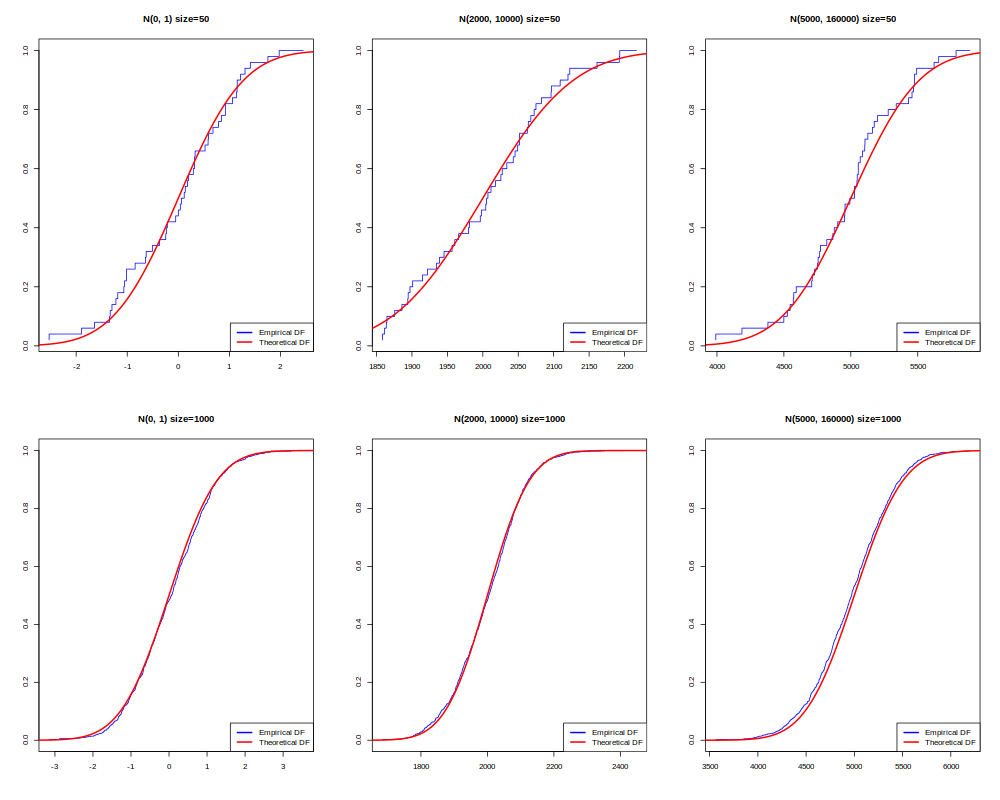

In [122]:
%%R -h 800 -w 1000
par(mfrow=c(2,3))

graph1 <- graph_distr_fun(sample1, 0, 1, 50)
graph2 <- graph_distr_fun(sample2, 2000, 100, 50)
graph3 <- graph_distr_fun(sample3, 5000, 400, 50)
graph4 <- graph_distr_fun(sample4, 0, 1, 1000)
graph5 <- graph_distr_fun(sample5, 2000, 100, 1000)
graph6 <- graph_distr_fun(sample6, 5000, 400, 1000)

# QQplot

In [123]:
from statsmodels.graphics.gofplots import qqplot

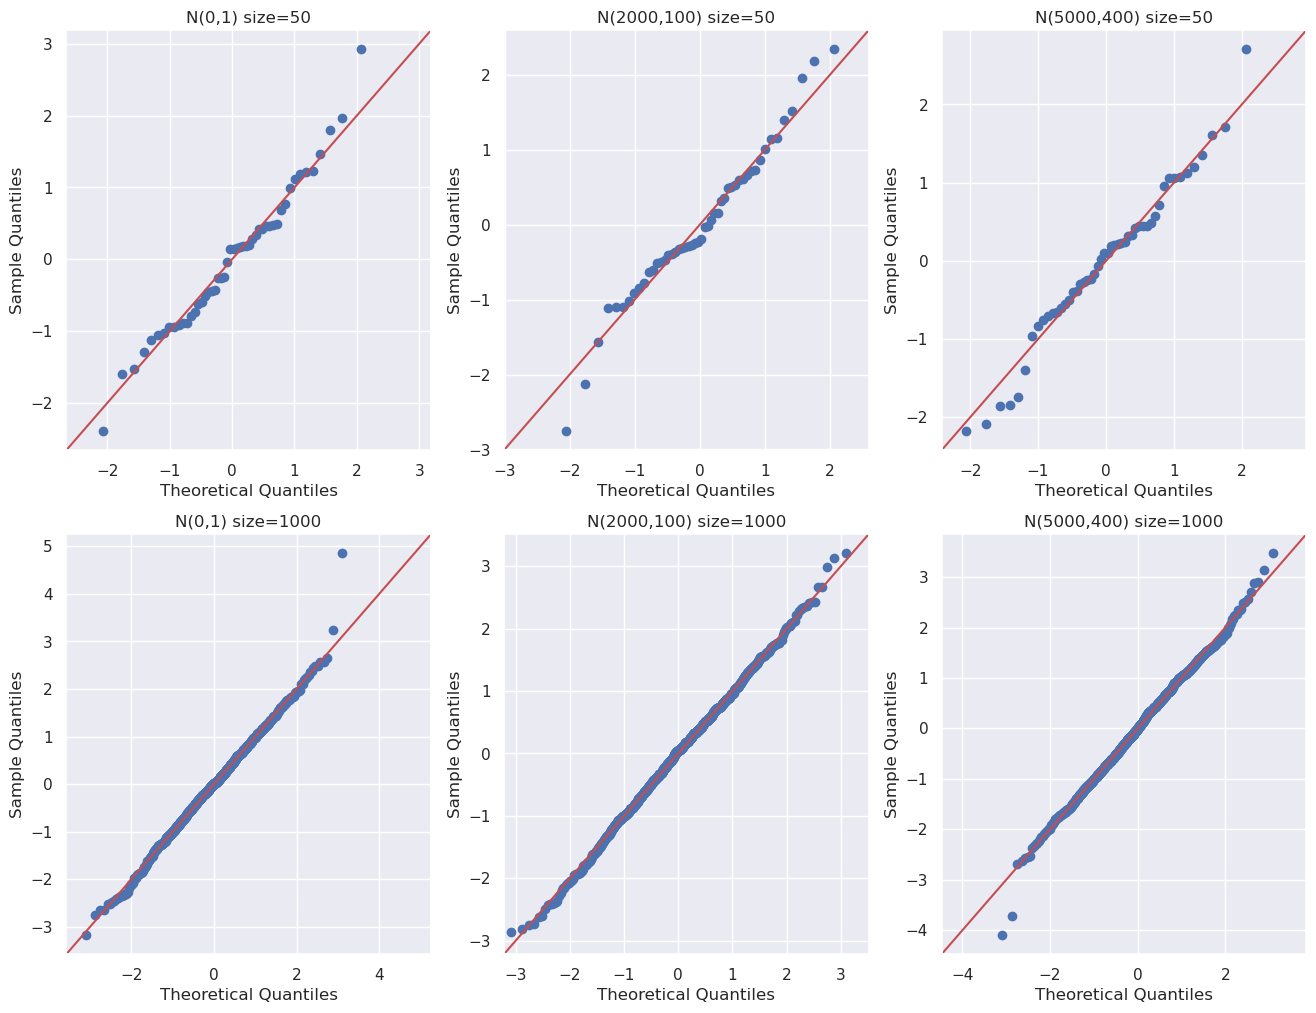

In [124]:
f, axes = plt.subplots(2,3, figsize=(16, 12))#, sharex=True, sharey=True) # 1 row, 1 column

for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]

        qqplot(sample, fit=True, line="45",ax = axes[j, i]);
        axes[j, i].title.set_text(f"N({locs[i]},{scales[i]}) size={sizes[j]}")

In [125]:
%%R
qqgraph <- function(sample, i){
  qqnorm(sample, main=glue("sample{i}"))
  qqline(sample)
}

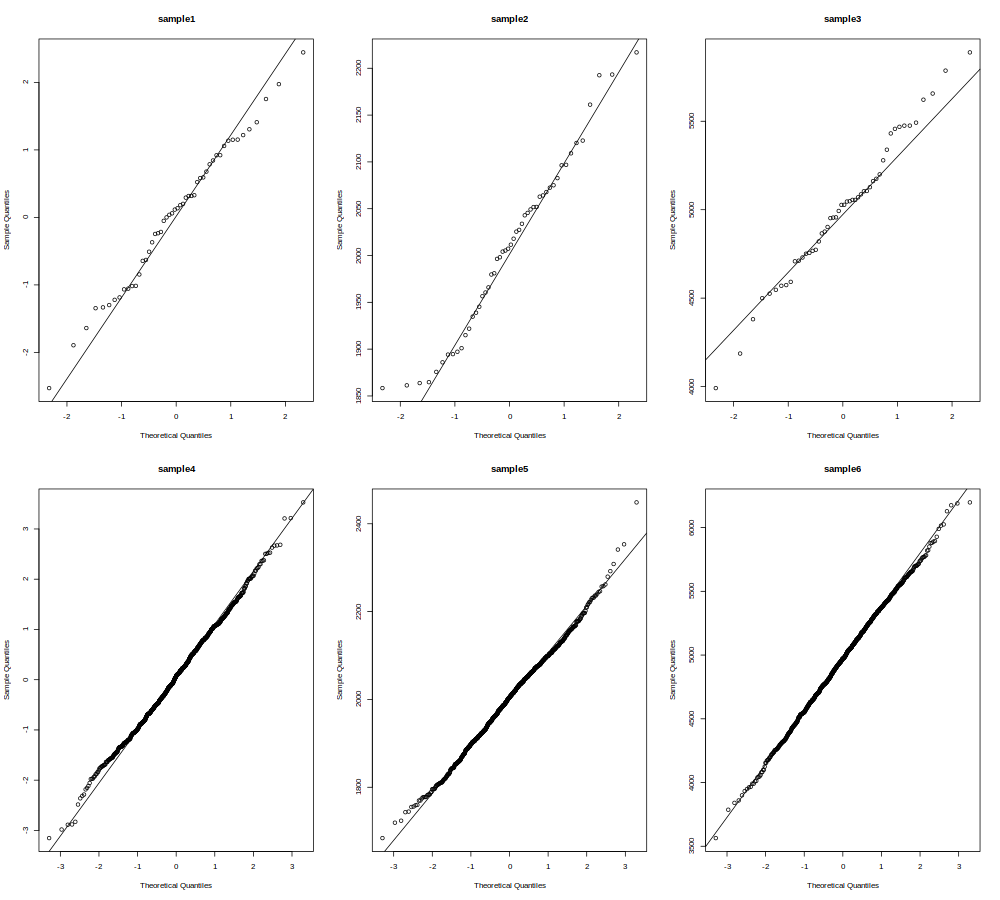

In [126]:
%%R -h 900 -w 1000
par(mfrow=c(2,3))
qqgraph(sample1, 1)
qqgraph(sample2, 2)
qqgraph(sample3, 3)
qqgraph(sample4, 4)
qqgraph(sample5, 5)
qqgraph(sample6, 6)

# Метод Огибающих

In [127]:
%%R
envelmet <- function(x, i){
  z <- (x - mean(x))/sqrt(var(x))  #  Стандартизация выборки
  x.qq <- qqnorm(z, plot.it = FALSE)
  x.qq <- lapply(x.qq, sort)
  plot(x.qq, ylim = c(-10, 10), ylab = "Z-статистики выборки", 
  xlab = "Квантили", main = glue("sample{i}"))
}

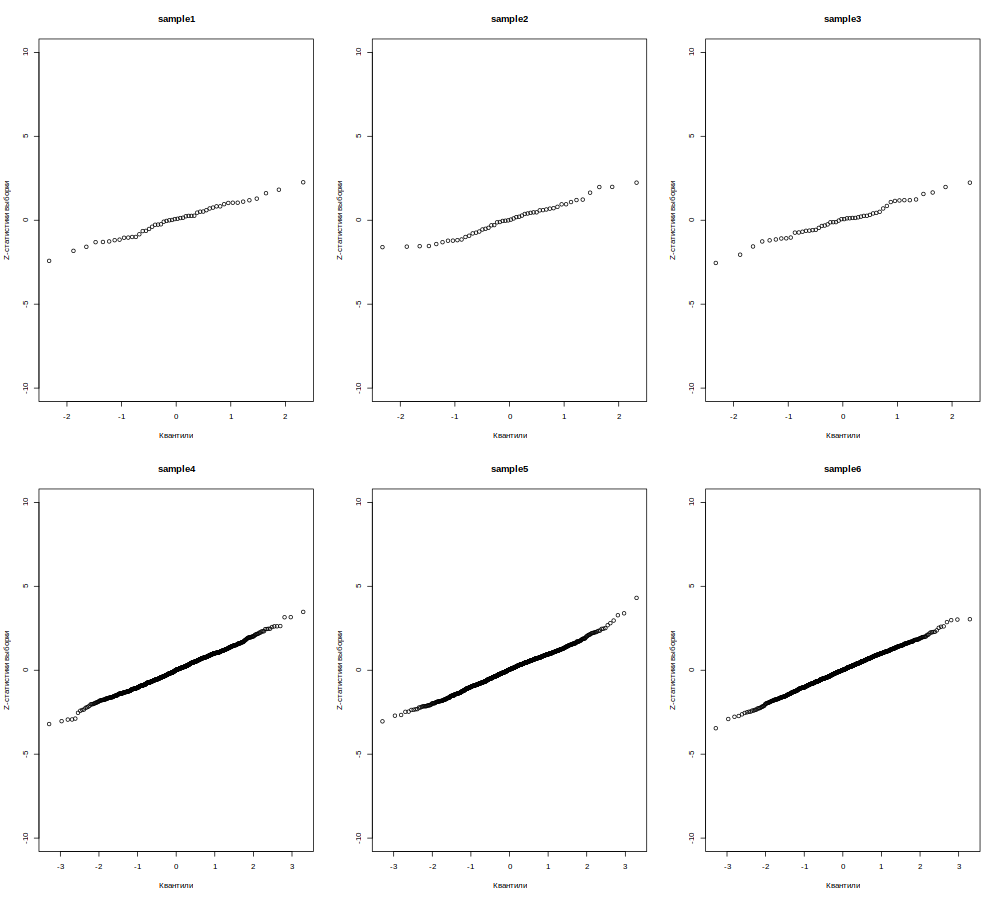

In [128]:
%%R -h 900 -w 1000
par(mfrow=c(2,3))

envelmet(sample1, 1)
envelmet(sample2, 2)
envelmet(sample3, 3)
envelmet(sample4, 4)
envelmet(sample5, 5)
envelmet(sample6, 6)

# Тест Колмогорова-Смирнова

In [129]:
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = stats.kstest(sample, "norm", args=(locs[i], scales[i]))
        print(f"size = {sizes[j]}, mean = {locs[i]}, std = {scales[i]}\n{stat = }, {pvalue = }\n")

size = 50, mean = 0, std = 1
stat = 0.11087380395389412, pvalue = 0.5338428347822113

size = 50, mean = 2000, std = 100
stat = 0.26963764718942484, pvalue = 0.0010601636489873112

size = 50, mean = 5000, std = 400
stat = 0.09757644282275815, pvalue = 0.6912624236083766

size = 1000, mean = 0, std = 1
stat = 0.023816976233157705, pvalue = 0.6131150522766826

size = 1000, mean = 2000, std = 100
stat = 0.037436392823974596, pvalue = 0.1182161633896347

size = 1000, mean = 5000, std = 400
stat = 0.04049561991011519, pvalue = 0.07322881555579652



### На уровне значимости 0.05 отвергается только второй тест. Во всех остальных случаях гипотеза H0 не отвергается на любом разумном уровне значимости.

In [130]:
%%R
print(ks.test(sample1, "pnorm", 0, 1))
print(ks.test(sample2, "pnorm", 2000, 100))
print(ks.test(sample3, "pnorm", 5000, 400))
print(ks.test(sample4, "pnorm", 0, 1))
print(ks.test(sample5, "pnorm", 2000, 100))
print(ks.test(sample6, "pnorm", 5000, 400))


	Exact one-sample Kolmogorov-Smirnov test

data:  sample1
D = 0.084781, p-value = 0.8352
alternative hypothesis: two-sided


	Exact one-sample Kolmogorov-Smirnov test

data:  sample2
D = 0.085634, p-value = 0.8264
alternative hypothesis: two-sided


	Exact one-sample Kolmogorov-Smirnov test

data:  sample3
D = 0.075667, p-value = 0.9163
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample4
D = 0.035083, p-value = 0.1705
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample5
D = 0.029701, p-value = 0.3409
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample6
D = 0.042273, p-value = 0.05609
alternative hypothesis: two-sided



### Гипотеза H0 не отвергается на любом разумном уровне значимости.

# Тест Андерсона-Дарлинга

Замечание statsmodels.stats.diagnostic.normal_ad возьмёт в качестве параметров распределия  
выборочное среднее и несмещённое стандартное отклонение

In [131]:
from statsmodels.stats.diagnostic import normal_ad as ad_test
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = ad_test(sample)
        print(f"size = {sizes[j]}, mean = {locs[i]}, std = {scales[i]}\n{stat = }, {pvalue = }\n")

size = 50, mean = 0, std = 1
stat = 0.3284757445725859, pvalue = 0.5090516315036815

size = 50, mean = 2000, std = 100
stat = 0.39824534649816457, pvalue = 0.3536776707970687

size = 50, mean = 5000, std = 400
stat = 0.36570718892997434, pvalue = 0.4220963189661951

size = 1000, mean = 0, std = 1
stat = 0.26437094573930153, pvalue = 0.6960711193858642

size = 1000, mean = 2000, std = 100
stat = 0.2939425945255607, pvalue = 0.5997004513100976

size = 1000, mean = 5000, std = 400
stat = 0.3776037921613806, pvalue = 0.40805838472844136



### Гипотеза H0 не отвергается на любом разумном уровне значимости.

In [73]:
%%R
library(nortest)
print(ad.test(sample1))
print(ad.test(sample2))
print(ad.test(sample3))
print(ad.test(sample4))
print(ad.test(sample5))
print(ad.test(sample6))


	Anderson-Darling normality test

data:  sample1
A = 0.24354, p-value = 0.7531


	Anderson-Darling normality test

data:  sample2
A = 0.32381, p-value = 0.5162


	Anderson-Darling normality test

data:  sample3
A = 0.26737, p-value = 0.6723


	Anderson-Darling normality test

data:  sample4
A = 0.49518, p-value = 0.214


	Anderson-Darling normality test

data:  sample5
A = 0.64638, p-value = 0.09149


	Anderson-Darling normality test

data:  sample6
A = 0.21722, p-value = 0.8423



### Гипотеза H0 не отвергается на любом разумном уровне значимости во всех тестах.

# Тест Крамера фон Мизеса

In [132]:
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = stats.cramervonmises(sample, 'norm', args=(locs[i], scales[i])).statistic,\
                       stats.cramervonmises(sample, 'norm', args=(locs[i], scales[i])).pvalue
        print(f"N({locs[i]},{scales[i]}) size = {sizes[j]}\n{stat = }, {pvalue = }\n")

N(0,1) size = 50
stat = 0.12652494232185194, pvalue = 0.471115074223003

N(2000,100) size = 50
stat = 1.2541789925257294, pvalue = 0.0005647028245521213

N(5000,400) size = 50
stat = 0.10316500672021948, pvalue = 0.5713490414786984

N(0,1) size = 1000
stat = 0.1331765266323705, pvalue = 0.44523128030753534

N(2000,100) size = 1000
stat = 0.22875401970998865, pvalue = 0.2180637673180137

N(5000,400) size = 1000
stat = 0.2767326345325914, pvalue = 0.1574322680760989



### На уровне значимости 0.05 отвергается только второй тест. Во всех остальных случаях гипотеза H0 не отвергается на любом разумном уровне значимости.

In [133]:
%%R
print(cvm.test(sample1))
print(cvm.test(sample2))
print(cvm.test(sample3))
print(cvm.test(sample4))
print(cvm.test(sample5))
print(cvm.test(sample6))


	Cramer-von Mises normality test

data:  sample1
W = 0.039777, p-value = 0.6787


	Cramer-von Mises normality test

data:  sample2
W = 0.036421, p-value = 0.7404


	Cramer-von Mises normality test

data:  sample3
W = 0.045425, p-value = 0.5748


	Cramer-von Mises normality test

data:  sample4
W = 0.073263, p-value = 0.2533


	Cramer-von Mises normality test

data:  sample5
W = 0.10042, p-value = 0.1108


	Cramer-von Mises normality test

data:  sample6
W = 0.030303, p-value = 0.8431



### Гипотеза H0 не отвергается на любом разумном уровне значимости во всех тестах.

# Тест Лиллиефорса

In [76]:
from statsmodels.stats.diagnostic import lilliefors
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = lilliefors(sample)
        print(f"N({locs[i]},{scales[i]}) size = {sizes[j]}\n{stat = }, {pvalue = }\n")

N(0,1) size = 50
stat = 0.09094304530212571, pvalue = 0.38251689669786665

N(2000,100) size = 50
stat = 0.09673490336287588, pvalue = 0.285091826676084

N(5000,400) size = 50
stat = 0.07740043368658112, pvalue = 0.6327170990270895

N(0,1) size = 1000
stat = 0.018134858368808904, pvalue = 0.6673259768130475

N(2000,100) size = 1000
stat = 0.023567129594584513, pvalue = 0.2495968600544056

N(5000,400) size = 1000
stat = 0.024223599927328254, pvalue = 0.22257001590552922



### Гипотеза H0 не отвергается на любом разумном уровне значимости во всех тестах.

In [77]:
%%R
print(lillie.test(sample1))
print(lillie.test(sample2))
print(lillie.test(sample3))
print(lillie.test(sample4))
print(lillie.test(sample5))
print(lillie.test(sample6))


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample1
D = 0.080018, p-value = 0.5873


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample2
D = 0.07425, p-value = 0.7022


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample3
D = 0.075788, p-value = 0.6719


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample4
D = 0.021112, p-value = 0.3447


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample5
D = 0.022622, p-value = 0.246


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample6
D = 0.014012, p-value = 0.905



### Гипотеза H0 не отвергается на любом разумном уровне значимости во всех тестах.

# Тест Шапиро-Уилка

Ограничение на размер выборки 5000. Мы проходим.

In [78]:
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = stats.shapiro(sample)
        print(f"N({locs[i]},{scales[i]}) size = {sizes[j]}\n{stat = }, {pvalue = }\n")

N(0,1) size = 50
stat = 0.9832391738891602, pvalue = 0.6940747499465942

N(2000,100) size = 50
stat = 0.9803583025932312, pvalue = 0.5671716928482056

N(5000,400) size = 50
stat = 0.9796740412712097, pvalue = 0.5382983088493347

N(0,1) size = 1000
stat = 0.9969052076339722, pvalue = 0.04884222522377968

N(2000,100) size = 1000
stat = 0.9987080693244934, pvalue = 0.6939663290977478

N(5000,400) size = 1000
stat = 0.9978259205818176, pvalue = 0.2171912044286728



In [79]:
%%R
print(shapiro.test(sample1))
print(shapiro.test(sample2))
print(shapiro.test(sample3))
print(shapiro.test(sample4))
print(shapiro.test(sample5))
print(shapiro.test(sample6))


	Shapiro-Wilk normality test

data:  sample1
W = 0.98986, p-value = 0.9429


	Shapiro-Wilk normality test

data:  sample2
W = 0.97013, p-value = 0.2342


	Shapiro-Wilk normality test

data:  sample3
W = 0.98848, p-value = 0.9043


	Shapiro-Wilk normality test

data:  sample4
W = 0.99808, p-value = 0.3174


	Shapiro-Wilk normality test

data:  sample5
W = 0.99677, p-value = 0.03891


	Shapiro-Wilk normality test

data:  sample6
W = 0.99901, p-value = 0.8761



### Гипотеза H0 не отвергается на любом разумном уровне значимости во всех тестах.

# 6. Анализ данных с помощью графиков квантилей, метода огибающих, а также стандартных процедур проверки гипотез о нормальности на реальных данных.

### Построим qqplot для некоторых признаков. Видим, что распределение признаков отвечающих за габариты (оссобенно за длину и ширину) больше похожи на нормальные. 

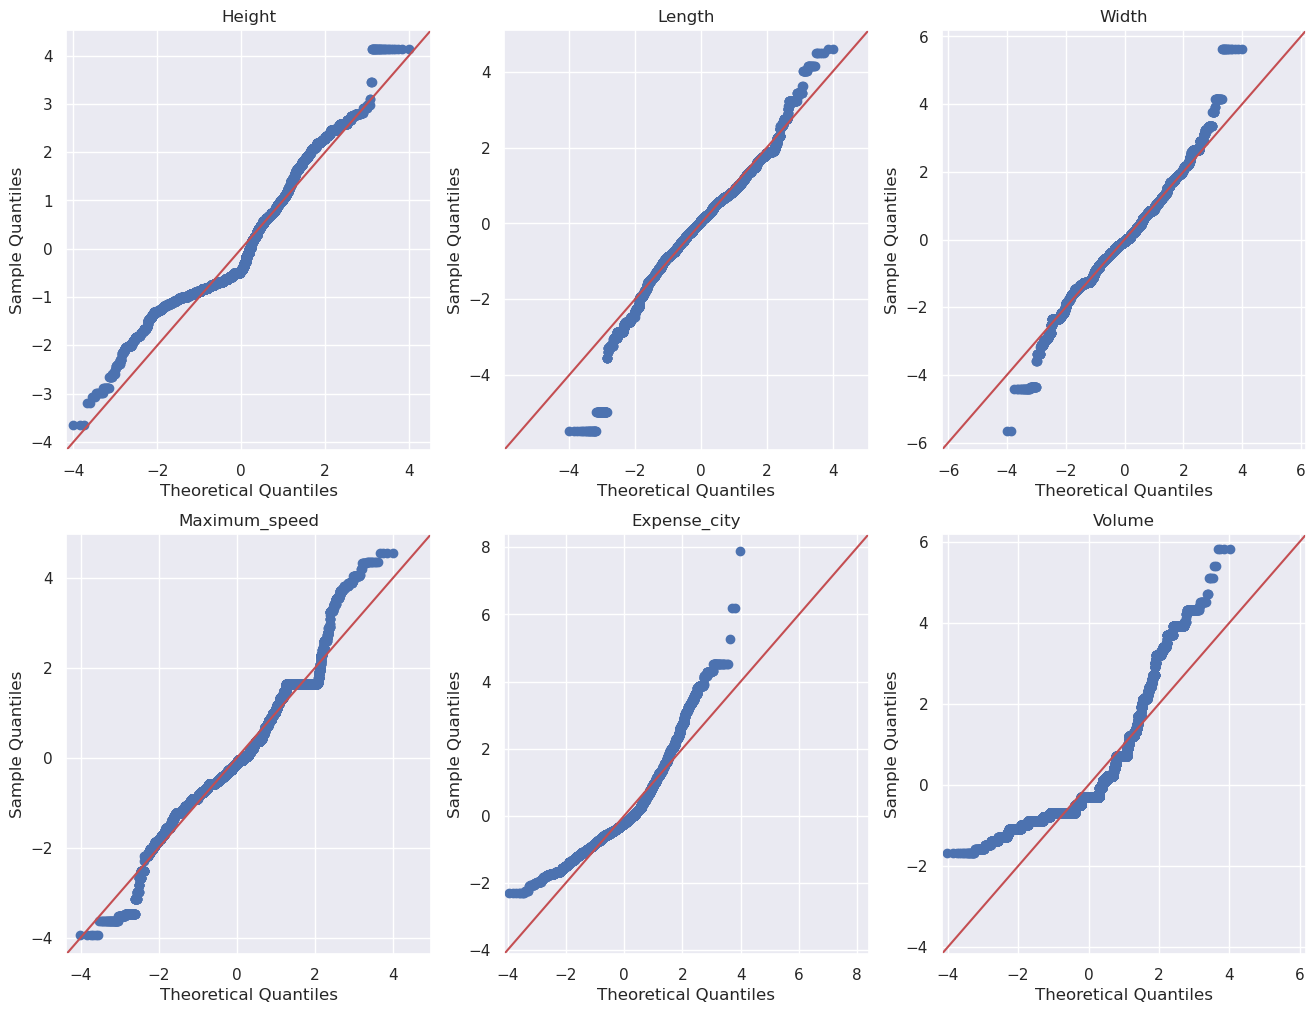

In [134]:
f, axes = plt.subplots(2,3, figsize=(16, 12))#, sharex=True, sharey=True) # 1 row, 1 column

qqplot(df.Height, fit=True, line="45",ax = axes[0, 0]);
axes[0, 0].title.set_text("Height")

qqplot(df.Length, fit=True, line="45",ax = axes[0, 1]);
axes[0, 1].title.set_text("Length")

qqplot(df.Width, fit=True, line="45",ax = axes[0, 2]);
axes[0, 2].title.set_text("Width")

qqplot(df.Maximum_speed, fit=True, line="45",ax = axes[1, 0]);
axes[1, 0].title.set_text("Maximum_speed")

qqplot(df.Expense_city[df.Expense_city != 0], fit=True, line="45",ax = axes[1, 1]);
axes[1, 1].title.set_text("Expense_city")

qqplot(df.Volume[df.Volume != 0], fit=True, line="45",ax = axes[1, 2]);
axes[1, 2].title.set_text("Volume")

In [135]:
%%R
qqgraph <- function(sample, name){
  qqnorm(sample, main=name)
  qqline(sample)
}

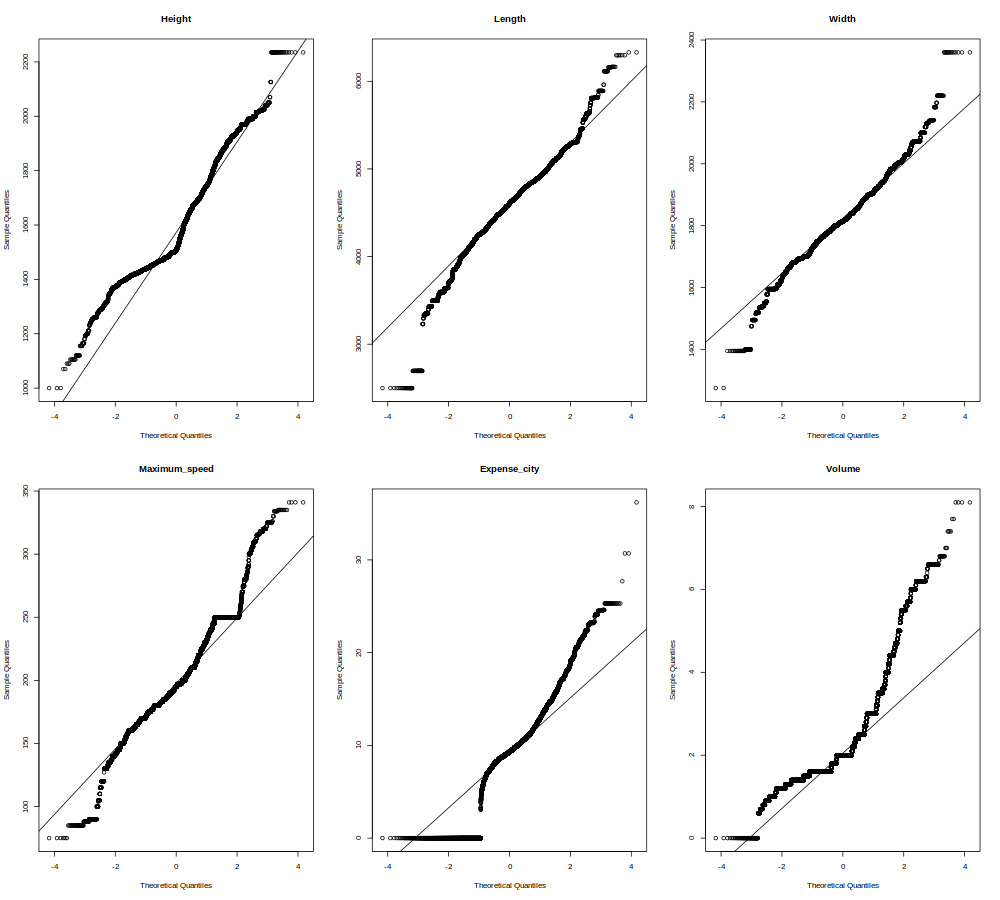

In [136]:
%%R -h 900 -w 1000
par(mfrow=c(2,3))

qqgraph(df$Height, "Height")
qqgraph(df$Length, "Length")
qqgraph(df$Width, "Width")
qqgraph(df$Maximum_speed, "Maximum_speed")
qqgraph(df$Expense_city, "Expense_city")
qqgraph(df$Volume, "Volume")

### Создадим выборки для длины, ширины и проведём на них тест на нормальность.

In [137]:
sample_width = df.Width
sample_length = df.Length

In [138]:
%%R
sample_width <- df$Width
sample_length <- df$Length

### Тест Колмогорова-Смирнова

In [139]:
stat, pvalue = stats.kstest(sample_width, "norm", args=(sample_width.mean(), sample_width.std(ddof=1)))
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = stats.kstest(sample_length, "norm", args=(sample_length.mean(), sample_length.std(ddof=1)))
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 0.04779366016348641, pvalue = 1.804249640941521e-66

Length: stat = 0.04372578851510328, pvalue = 1.056606050413227e-55



In [140]:
%%R
print(ks.test(sample_width, "pnorm", mean(sample_width), sd(sample_width)))
print(ks.test(sample_length, "pnorm", mean(sample_length), sd(sample_length)))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample_width
D = 0.047794, p-value < 2.2e-16
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample_length
D = 0.043726, p-value < 2.2e-16
alternative hypothesis: two-sided



In addition: Warning messages:
1: In ks.test.default(sample_width, "pnorm", mean(sample_width), sd(sample_width)) :
  ties should not be present for the Kolmogorov-Smirnov test
2: In ks.test.default(sample_length, "pnorm", mean(sample_length),  :
  ties should not be present for the Kolmogorov-Smirnov test


### Тест Андерсона-Дарлинга 

In [141]:
stat, pvalue = ad_test(sample_width)
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = ad_test(sample_length)
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 82.61473176228901, pvalue = 0.0

Length: stat = 115.78584548726212, pvalue = 0.0



In [142]:
%%R
print(ad.test(sample_width))
print(ad.test(sample_length))


	Anderson-Darling normality test

data:  sample_width
A = 82.615, p-value < 2.2e-16


	Anderson-Darling normality test

data:  sample_length
A = 115.79, p-value < 2.2e-16



### Тест Лиллиефорса

In [143]:
stat, pvalue = lilliefors(sample_width)
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = lilliefors(sample_length)
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 0.04779366016348652, pvalue = 0.0009999999999998899

Length: stat = 0.04372578851510178, pvalue = 0.0009999999999998899



In [144]:
%%R
print(lillie.test(sample_width))
print(lillie.test(sample_length))


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample_width
D = 0.047794, p-value < 2.2e-16


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample_length
D = 0.043726, p-value < 2.2e-16



### Тест Шапиро-Уилка

In [145]:
stat, pvalue = stats.shapiro(sample_width)
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = stats.shapiro(sample_length)
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 0.988805890083313, pvalue = 1.0930128021733573e-43

Length: stat = 0.9785880446434021, pvalue = 0.0



In [146]:
%%R
print(shapiro.test(sample(sample_width, 5000)))
print(shapiro.test(sample(sample_length, 5000)))


	Shapiro-Wilk normality test

data:  sample(sample_width, 5000)
W = 0.99185, p-value = 2.303e-16


	Shapiro-Wilk normality test

data:  sample(sample_length, 5000)
W = 0.97658, p-value < 2.2e-16



### Как видим выше, несмотря на неплохие графики qqplot все тесты уверенно отвергают гипотезу о том, что признаки распределны нормально. 

# 7. Проверка различных гипотез на разных доверительных уровнях (0.9, 0.95, 0.99) следующих критериев:
- ### Стьюдента, включая односторонние варианты, когда проверяемая нулевая гипотеза заключается в том, что одно из сравниваемых средних значений больше (или меньше) другого. Реализовать оценку мощности критериев при заданном объеме выборки или определения объема выборки для достижения заданной мощности;
- ### Уилкоксона-Манна-Уитни (ранговые);
- ### Фишера, Левене, Бартлетта, Флигнера-Килина (проверка гипотез об однородности дисперсий).

## Mercedes-Benz и BMW - две крупные конкурирующие компании. Проверим гипотезу о том, что средняя цена автомобилей этих двух марок одинакова. Альтернатива $-$ среднее Мерседеса больше.
$
H_0: \mu_{mercedes} = \mu_{bmw} \\
H_1: \mu_{mercedes} - \mu_{bmw} > 0
$

In [147]:
price_bmw = df.loc[df.mark == "BMW", "Price"].dropna().values
price_mercedes = df.loc[df.mark == "Mercedes-Benz", "Price"].dropna().values
print("Средняя цена на Mercedes:", price_mercedes.mean())
print("Средняя цена на BMW:", price_bmw.mean())

Средняя цена на Mercedes: 3315851.6189176897
Средняя цена на BMW: 3086046.5418165466


### Проверим выборки на нормальность тестами Колмогорова-Смирнова и Шапиро-Уилка.

In [148]:
stat, pvalue = stats.kstest(price_bmw, "norm", args=(price_bmw.mean(), price_bmw.std(ddof=1)))
print(f"Price BMW:\n\nKS: {stat = }, {pvalue = }")
stat, pvalue = stats.shapiro(price_bmw)
print(f"SW: {stat = }, {pvalue = }\n")

stat, pvalue = stats.kstest(price_mercedes, "norm", args=(price_mercedes.mean(), price_mercedes.std(ddof=1)))
print(f"Price Mercedes:\n\nKS: {stat = }, {pvalue = }")
stat, pvalue = stats.shapiro(price_mercedes)
print(f"SW: {stat = }, {pvalue = }\n")

Price BMW:

KS: stat = 0.15983274183215634, pvalue = 4.2275640115780137e-50
SW: stat = 0.8199724555015564, pvalue = 1.6815581571897805e-44

Price Mercedes:

KS: stat = 0.21194317463517962, pvalue = 3.7308775235627754e-87
SW: stat = 0.6904414892196655, pvalue = 0.0



### Видим, что на любом разумном уровне значимости данные противоречат гипотезе о нормальности.

## Применим преобразование Бокса-Кокса и проверим на нормальность ещё раз.

[Text(0.5, 1.0, 'Transformed Price Mercedes')]

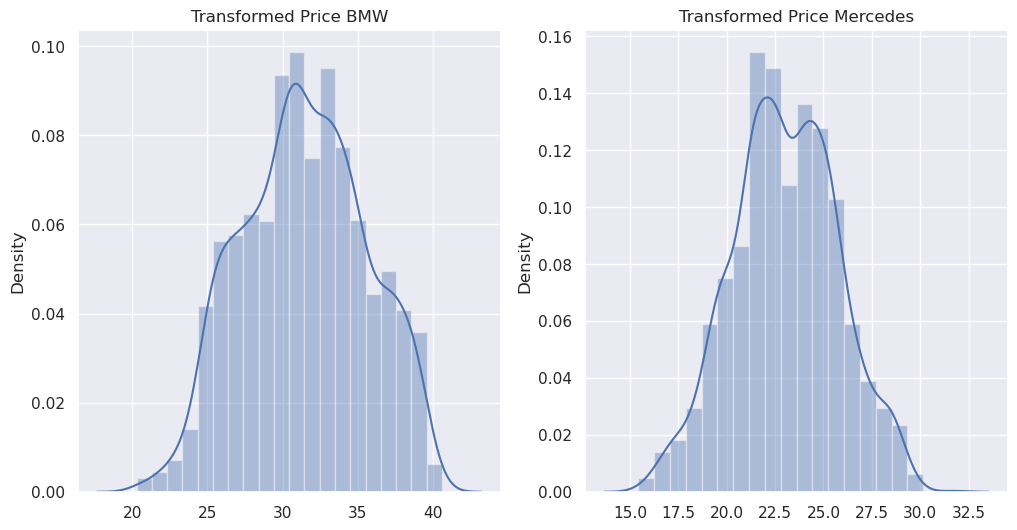

In [149]:
from scipy. stats import boxcox 
transformed_bmw, best_lambda = boxcox(price_bmw)
transformed_mer, best_lambda = boxcox(price_mercedes) 

f, axs = plt.subplots(1, 2, figsize=(12, 6))#, sharex=True, sharey=True) # 1 row, 1 column

sns.distplot(transformed_bmw, kde= True, bins=20, ax=axs[0]).set(title='Transformed Price BMW')
sns.distplot(transformed_mer, kde= True, bins=20, ax=axs[1]).set(title='Transformed Price Mercedes')

In [150]:
stat, pvalue = stats.kstest(transformed_bmw, "norm", args=(transformed_bmw.mean(), transformed_bmw.std(ddof=1)))
print(f"Price BMW:\n\nKS: {stat = }, {pvalue = }")
stat, pvalue = stats.shapiro(transformed_bmw)
print(f"SW: {stat = }, {pvalue = }\n")

stat, pvalue = stats.kstest(transformed_mer, "norm", args=(transformed_mer.mean(), transformed_mer.std(ddof=1)))
print(f"Price Mercedes:\n\nKS: {stat = }, {pvalue = }")
stat, pvalue = stats.shapiro(transformed_mer)
print(f"SW: {stat = }, {pvalue = }\n")

Price BMW:

KS: stat = 0.033844449051005754, pvalue = 0.011972317775212323
SW: stat = 0.9884287118911743, pvalue = 2.0380925679769346e-12

Price Mercedes:

KS: stat = 0.02208050500172315, pvalue = 0.23053206833858286
SW: stat = 0.9969092011451721, pvalue = 0.00020320589828770608



### Гипотезы о нормальности опять отвергаются,  но данных достаточно много, поэтому будем использовать Z-тест.

***Наша статистика:***
$
z\_stat = \frac{\overline{Pr_{mer}} - \overline{Pr_{bmw}}}{\sqrt{\frac{se_{mer}^2}{n_{mer}} + \frac{se_{bmw}^2}{n_{bmw}}}} \\
$

In [151]:
#считаем средние
mean_bmw = price_bmw.mean()
mean_mer = price_mercedes.mean()

#считаем дисперсии
var_bmw = price_bmw.var(ddof=1)
var_mer = price_mercedes.var(ddof=1)

#размеры выборок
size_bmw = len(price_bmw)
size_mer = len(price_mercedes)

#статистика и p-value
z_stat = (mean_mer - mean_bmw) / np.sqrt(var_mer / size_mer + var_bmw / size_bmw)
p_value = 1 - stats.norm.cdf(z_stat)

print(f"{z_stat = } {p_value = }")

z_stat = 2.1368082916562896 p_value = 0.016306793729646607


### Проведём этот же тест в различных библиотеках и увидим, что результаты очень похожи.

In [152]:
from statsmodels.stats.weightstats import ztest
ztest(price_mercedes, price_bmw, alternative='larger')

(2.1404555422034766, 0.01615898499603192)

In [153]:
from scipy.stats import ttest_ind
ttest_ind(price_mercedes, price_bmw, alternative = 'greater')

TtestResult(statistic=2.140455542203477, pvalue=0.016186262486641394, df=4421.0)

In [154]:
import pingouin
pingouin.ttest(price_mercedes, price_bmw, alternative = 'greater', confidence = 0.95)

T          dof alternative     p-val            CI95%  cohen-d  \
T-test  2.136808  4027.805339     greater  0.016337  [52867.04, inf]  0.06437   

         BF10     power  
T-test  0.659  0.689797

### Мощность критерия равна 0.69.

In [155]:
%%R -i price_bmw -i price_mercedes
library(BSDA)
z.test(x=price_mercedes, y=price_bmw, sigma.x=sd(price_mercedes), sigma.y=sd(price_bmw), alternative = "greater")


	Two-sample z-Test

data:  price_mercedes and price_bmw
z = 2.1368, p-value = 0.01631
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 52907.73       NA
sample estimates:
mean of x mean of y 
  3315852   3086047 



Loading required package: lattice

Attaching package: ‘BSDA’

The following object is masked from ‘package:datasets’:

    Orange



### У нас не хватает обоснований отвергнуть гипотезу о равенстве средних.

## Критерий Манна-Уитни (двухвыборочный)


Предположения:
$
X_1, ..., X_{n_x} \sim iid \\
Y_1, ..., Y_{n_y} \sim iid
$
Распределения одинаковые по форме, различаются сдвигом. Выборки независимые.
Гипотезы:
$
H_0: f_X(x) = f_Y(y) \\
H_1: f_X(x) = f_Y(y + m), \: m \neq 0
$
U-статистика:  
$
U = (N_1 * N_2) + \frac{N_x(N_x + 1)}{2} - T_x
$
где $N_1$ и $_2$- объёмы выборок; $T_x, N_x$ - большая ранговая сумма и объём выборки большей ранговой суммы.

При размере выборки более 60 U-статистика хорошо апроксимируется нормальный распределением, поэтому p-value считаем по нормальной функции распределения.
$
z = \frac{U - m_U}{\sigma_U}\\
m_U = \frac{N_1 * N_2}{2} \\
\sigma_U = \sqrt{\frac{N_1 * N_2 (N_1 + N_2 + 1)}{12}}
$


In [156]:
def MannWhitney(x, y, rank_x, rank_y):
    U = min(rank_x - x.count() * (x.count() + 1) / 2,\
            rank_y - y.count() * (y.count() + 1) / 2)
    m_u = x.count() * y.count() / 2
    sigma_u = np.sqrt(x.count() * y.count() * (x.count() + y.count() + 1) / 12)
    z_score = (U - m_u) / sigma_u
    p_value = stats.norm.cdf(z_score)
    print("U-критерий", U, f"{p_value = }")

## Разделим все автомобили на две выборки, выпущенные до и после 2012 года. И протестируем гипотезу о том, что распределения максимальной мощности одинаковы.

In [157]:
old_cars = df.loc[df.Year <= 2012, ["Maximum_power"]]
new_cars = df.loc[df.Year > 2012, ["Maximum_power"]]

## Конечно мы работаем в предположении того, что формы двух распределений одинаковы. Гистограммы ниже этому не противоречат.

[Text(0.5, 1.0, 'New cars')]

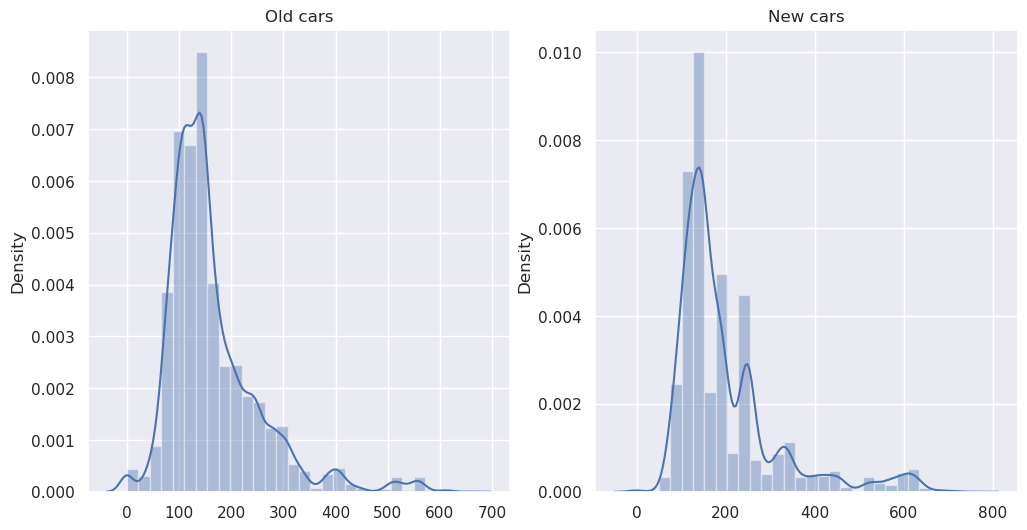

In [158]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.distplot(old_cars, kde=True, bins=30, ax=axs[0]).set(title='Old cars')
sns.distplot(new_cars, kde=True, bins=30, ax=axs[1]).set(title='New cars')

In [159]:
df1 = df.loc[:, ["Year", "Maximum_power"]].dropna()
df1["rank"] = df1["Maximum_power"].rank(ascending = False, numeric_only=True)

rank_old = df1.loc[df1.Year <= 2012, "rank"].sum()
rank_new = df1.loc[df1.Year > 2012, "rank"].sum()

### Значение статистики и p-value собственной реализации:

In [160]:
MannWhitney(old_cars.Maximum_power, new_cars.Maximum_power, rank_old, rank_new)

U-критерий 109533640.5 p_value = 6.69135210299968e-235


### Результаты statsmodels:

In [161]:
stats.mannwhitneyu(old_cars.Maximum_power, new_cars.Maximum_power, alternative='two-sided')

MannwhitneyuResult(statistic=109533640.5, pvalue=9.048879412896212e-235)

In [162]:
%%R -i old_cars.Maximum_power -i new_cars.Maximum_power
wilcox.test(old_cars.Maximum_power, new_cars.Maximum_power)


	Wilcoxon rank sum test with continuity correction

data:  old_cars.Maximum_power and new_cars.Maximum_power
W = 109533640, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



### Значения статистики одинаковы, p-value очень близкие, но всё-таки разные, так как я считал его по нормальному распределению.

### Вывод: На любом разумном уровне значимости гипотеза H0 отвергается. Прогресс идёт и автомобили с годами становятся мощнее.

In [163]:
print("Mean maximum power for old cars:", old_cars.Maximum_power.mean(), \
      "\nMean maximum power for new cars:", new_cars.Maximum_power.mean())

Mean maximum power for old cars: 164.0941881435802 
Mean maximum power for new cars: 199.70059097978228


## Для примеров выше проведём различные тесты на однородность дисперсий.

### Тест Фишера:

In [164]:
%%R
var.test(price_mercedes, price_bmw)


	F test to compare two variances

data:  price_mercedes and price_bmw
F = 1.8639, num df = 2198, denom df = 2223, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.714784 2.026037
sample estimates:
ratio of variances 
          1.863906 



In [165]:
%%R
var.test(old_cars.Maximum_power, new_cars.Maximum_power)


	F test to compare two variances

data:  old_cars.Maximum_power and new_cars.Maximum_power
F = 0.59106, num df = 17188, denom df = 16074, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5733523 0.6093111
sample estimates:
ratio of variances 
          0.591063 



### У обеих выборок отвергается гипотеза о равенстве дисперсий на любом разумном уровне значимости.

### Тест Левене:

In [166]:
stats.levene(price_mercedes, price_bmw)

LeveneResult(statistic=13.098310776258485, pvalue=0.00029886936891833436)

In [167]:
%%R
library(car)
bmw_mer <- subset(df[,c("mark", "Price")], (mark == "BMW") | (mark == "Mercedes-Benz"))
leveneTest(Price ~ mark, data = bmw_mer)

Levene's Test for Homogeneity of Variance (center = median)
        Df F value    Pr(>F)    
group    1  13.098 0.0002989 ***
      4421                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Loading required package: carData

Attaching package: ‘carData’

The following objects are masked from ‘package:BSDA’:

    Vocab, Wool

In addition: Warning message:
In leveneTest.default(y = y, group = group, ...) : group coerced to factor.


In [168]:
stats.levene(old_cars.values[:,0], new_cars.values[:,0])

LeveneResult(statistic=253.2553988791944, pvalue=8.21671901787566e-57)

In [169]:
df_for_year = df.loc[:, ["Maximum_power", "Year"]]
df_for_year["group"] = 0
df_for_year.loc[df_for_year.Year > 2012, "group"] = 1
df_for_year.drop("Year", axis=1, inplace=True)

In [170]:
%%R -i df_for_year
df_for_year$group <- as.factor(df_for_year$group)
leveneTest(Maximum_power ~ group, data = df_for_year)

Levene's Test for Homogeneity of Variance (center = median)
         Df F value    Pr(>F)    
group     1  253.26 < 2.2e-16 ***
      33262                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### У обеих выборок отвергается гипотеза о равенстве дисперсий на любом разумном уровне значимости.

### Тест Бартлетта:

In [171]:
stats.bartlett(price_mercedes, price_bmw)

BartlettResult(statistic=211.07896566719293, pvalue=7.988567061995901e-48)

In [172]:
%%R
bartlett.test(Price ~ mark, data = bmw_mer)


	Bartlett test of homogeneity of variances

data:  Price by mark
Bartlett's K-squared = 211.08, df = 1, p-value < 2.2e-16



In [173]:
stats.bartlett(old_cars.values[:,0], new_cars.values[:,0])

BartlettResult(statistic=1141.905977493957, pvalue=2.5763980050518624e-250)

In [174]:
%%R
bartlett.test(Maximum_power ~ group, data = df_for_year)


	Bartlett test of homogeneity of variances

data:  Maximum_power by group
Bartlett's K-squared = 1141.9, df = 1, p-value < 2.2e-16



### У обеих выборок отвергается гипотеза о равенстве дисперсий на любом разумном уровне значимости.

### Тест Флингера-Килина:

In [175]:
stats.fligner(price_mercedes, price_bmw)

FlignerResult(statistic=1.7744215820403861, pvalue=0.1828358187188362)

In [176]:
%%R
fligner.test(Price ~ mark, data = bmw_mer)


	Fligner-Killeen test of homogeneity of variances

data:  Price by mark
Fligner-Killeen:med chi-squared = 1.7744, df = 1, p-value = 0.1828



### Выше видим, что для выборок цен на автомобили BMW и Mercedes у нас не хватает обоснований, чтобы отвегнуть гипотезу о равенстве дисперсий.

In [76]:
stats.fligner(old_cars, new_cars.values)

FlignerResult(statistic=82.52691144844523, pvalue=1.0424117849087915e-19)

In [77]:
%%R
fligner.test(Maximum_power ~ group, data = df_for_year)


	Fligner-Killeen test of homogeneity of variances

data:  Maximum_power by group
Fligner-Killeen:med chi-squared = 82.527, df = 1, p-value < 2.2e-16



### Гипотеза о равенстве дисперсий отвергается.

# 8.  Исследование корреляционных взаимосвязей в данных с помощью коэффициентов корреляции Пирсона, Спирмена и Кендалла.

In [179]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import operator

### Разделим признаки на количественные и качественные.

In [180]:
numeric_features = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].drop(['Price',\
        'Speed_to_100', 'Cylinders', 'Transmissions', "Seats", "Doors", "Restyling", "Electric_car",\
        "Volume", "Valves_per_cylinder", "Tire_width", "Aspect_ratio", "Wheel_diametr"]).index.values
categorical_features = df.dtypes[(df.dtypes == 'object') | (df.dtypes.index.isin(['Cylinders',\
    'Transmissions', "Seats", "Doors", "Restyling", "Valves_per_cylinder", "Tire_width",\
    "Aspect_ratio", "Wheel_diametr"]))].drop(['mark', 'Country', 'Color',\
    'Generation', 'Model']).index.values

## Корреляция Пиросона.

### Посмотрим на корреляцию с ценой автомобиля.

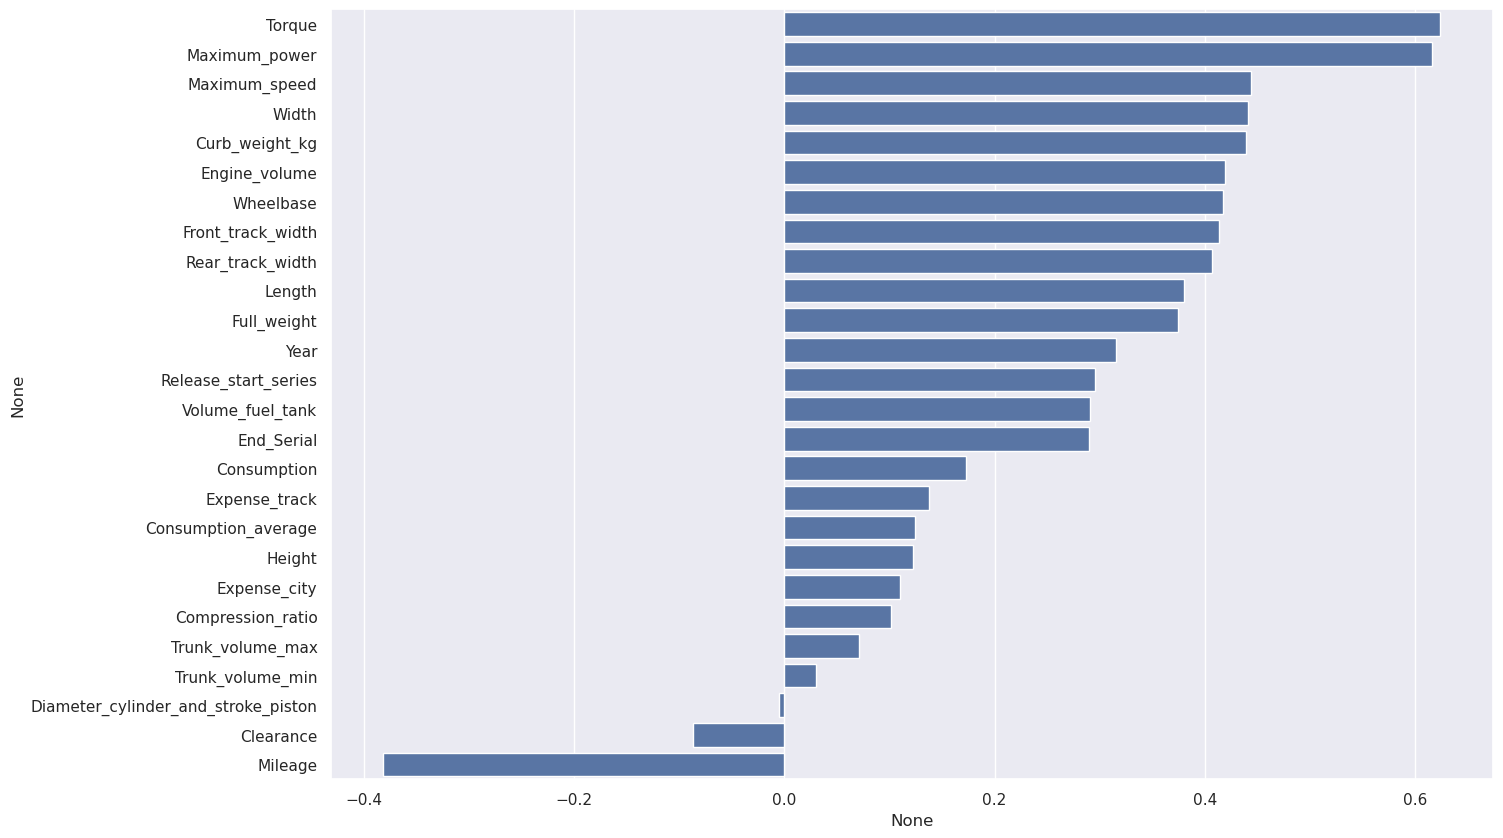

In [181]:
correlations_pirson = df[numeric_features].corrwith(df.Price, method='pearson').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

### Построим графики зависимости цены от признаков с самой высокой корреляцией.

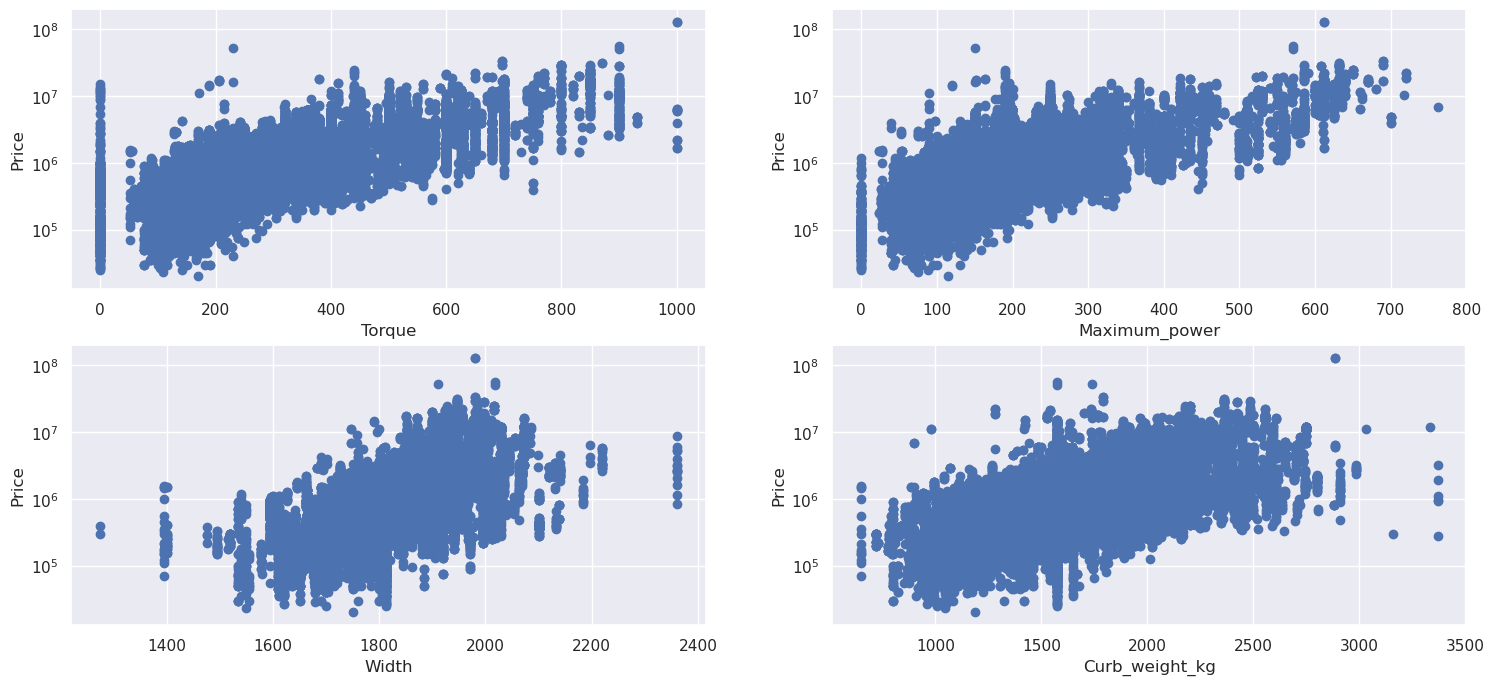

In [182]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
for i, feature in enumerate(['Torque', 'Maximum_power', 'Width', 'Curb_weight_kg']):
    axs[(i+2)//4, i%2].scatter(df[feature], df.Price)
    axs[(i+2)//4, i%2].set_xlabel(feature)
    axs[(i+2)//4, i%2].set_ylabel("Price")
    axs[(i+2)//4, i%2].set(yscale="log")

In [183]:
%%R
print(cor.test(df$Price, df$Torque, method = 'pearson'))
print(cor.test(df$Price, df$Maximum_power, method = 'pearson'))


	Pearson's product-moment correlation

data:  df$Price and df$Torque
t = 145.54, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6171428 0.6302740
sample estimates:
      cor 
0.6237524 


	Pearson's product-moment correlation

data:  df$Price and df$Maximum_power
t = 142.45, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6088489 0.6221982
sample estimates:
      cor 
0.6155677 



## Корреляция  Спирмена.

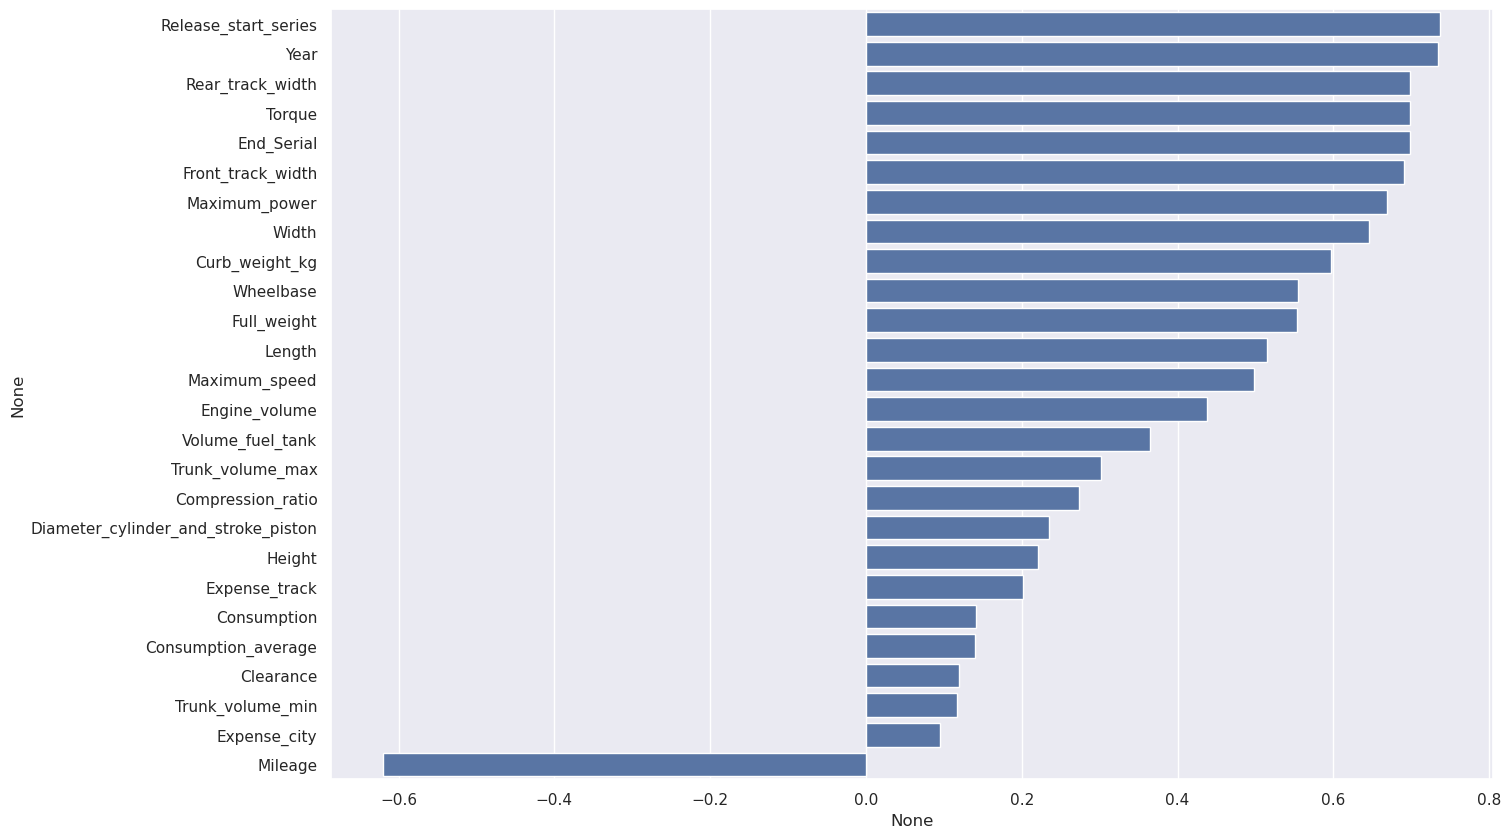

In [184]:
correlations_pirson = df[numeric_features].corrwith(df.Price, method='spearman').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [185]:
%%R
print(cor.test(df$Price, df$Torque, method = 'spearman'))
print(cor.test(df$Price, df$Year, method = 'spearman'))


	Spearman's rank correlation rho

data:  df$Price and df$Torque
S = 1.8475e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6988266 


	Spearman's rank correlation rho

data:  df$Price and df$Year
S = 1.6307e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.734174 



In addition: Warning messages:
1: In cor.test.default(df$Price, df$Torque, method = "spearman") :
  Cannot compute exact p-value with ties
2: In cor.test.default(df$Price, df$Year, method = "spearman") :
  Cannot compute exact p-value with ties


## Корреляция Кендалла.

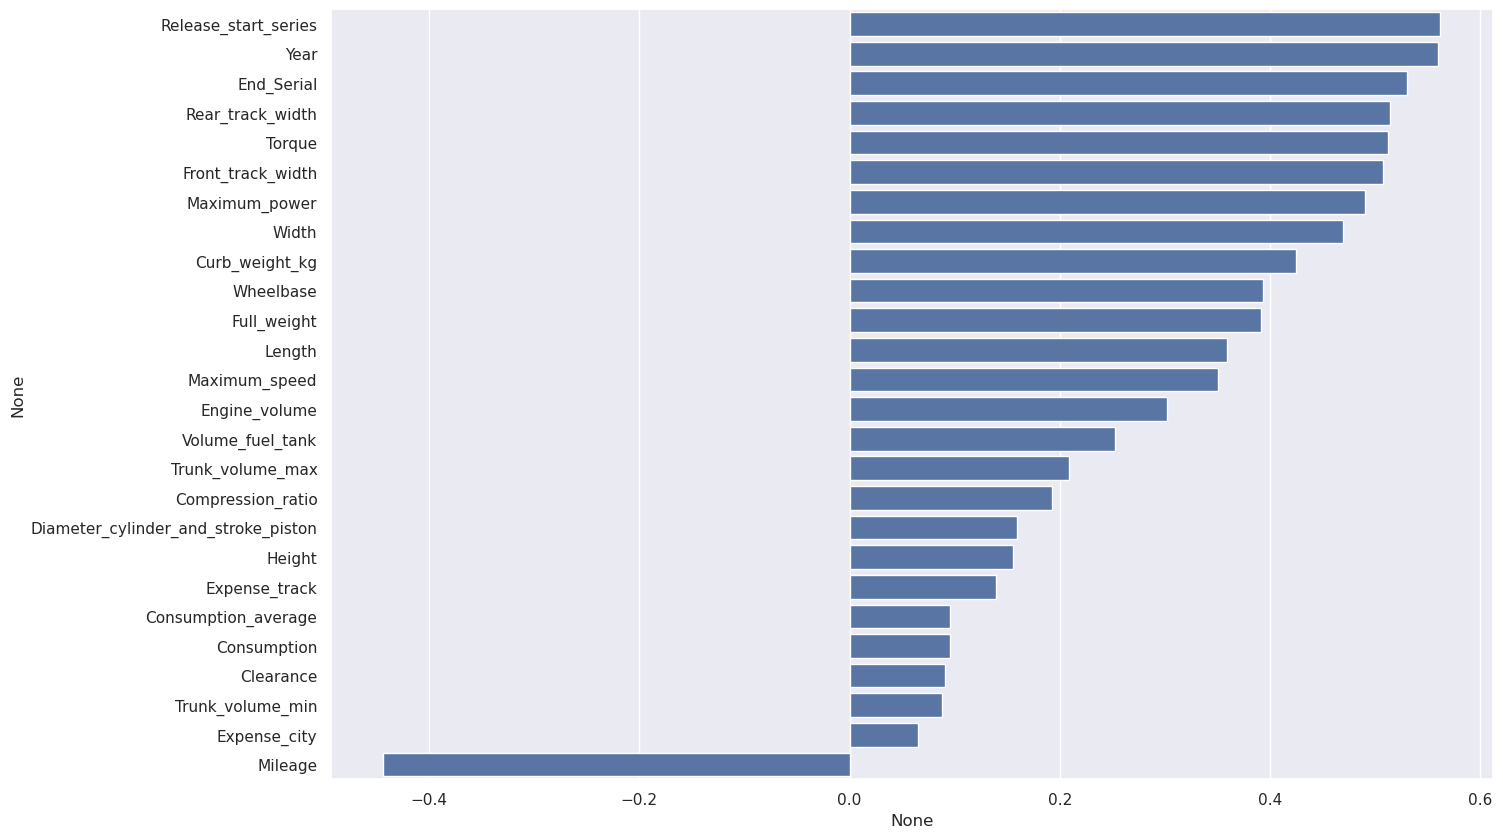

In [186]:
correlations_pirson = df[numeric_features].corrwith(df.Price, method='kendall').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [187]:
%%R
print(cor.test(df$Price, df$Torque, method = 'kendall'))
print(cor.test(df$Price, df$Year, method = 'kendall'))


	Kendall's rank correlation tau

data:  df$Price and df$Torque
z = 139.29, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5122107 


	Kendall's rank correlation tau

data:  df$Price and df$Year
z = 149.07, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5595668 



## Исследование корреляции со временем разгона до 100 км/ч.

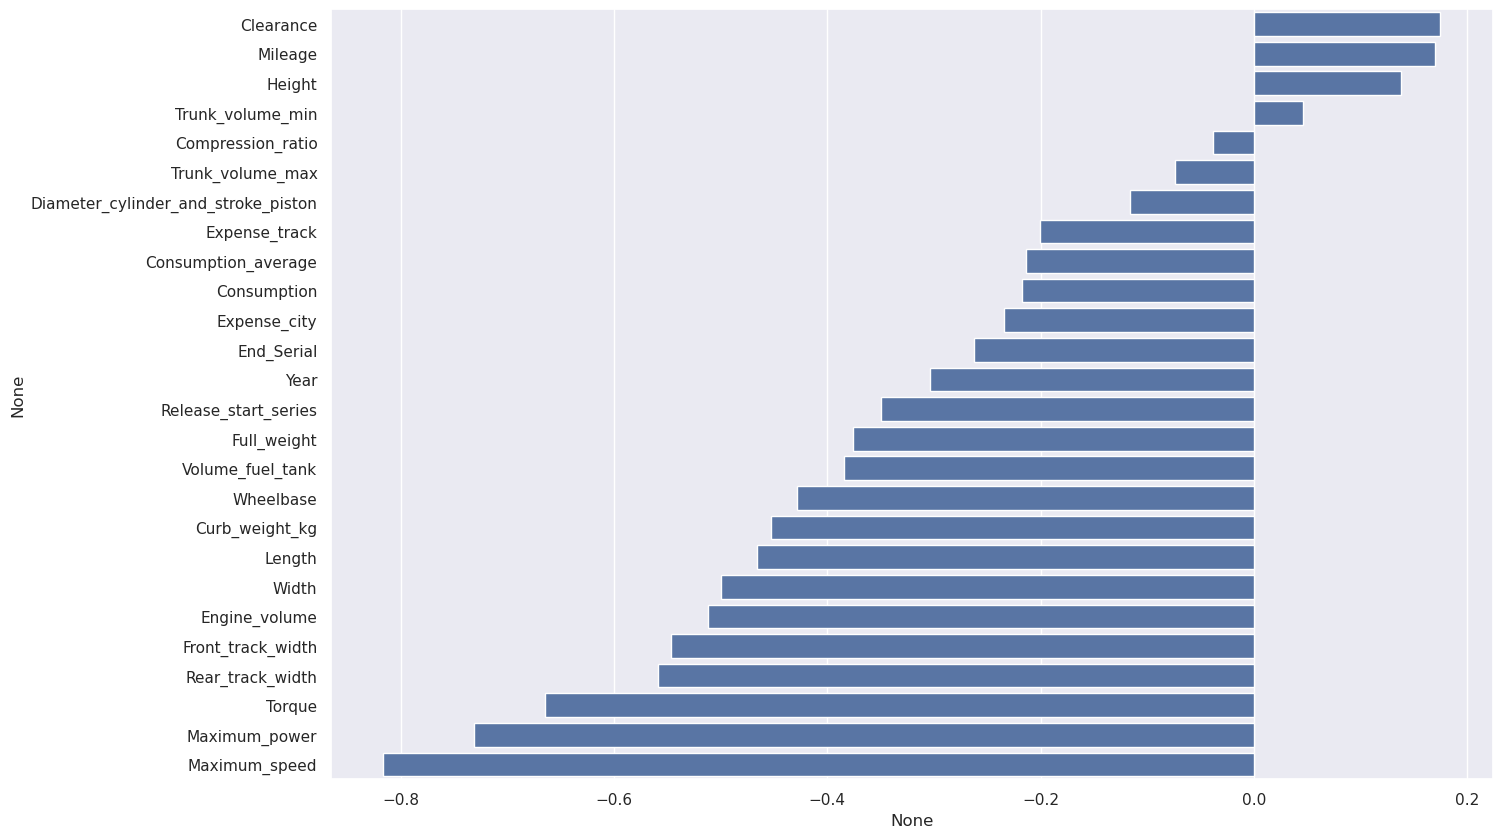

In [188]:
correlations_pirson = df[numeric_features].corrwith(df.Speed_to_100, method='pearson').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

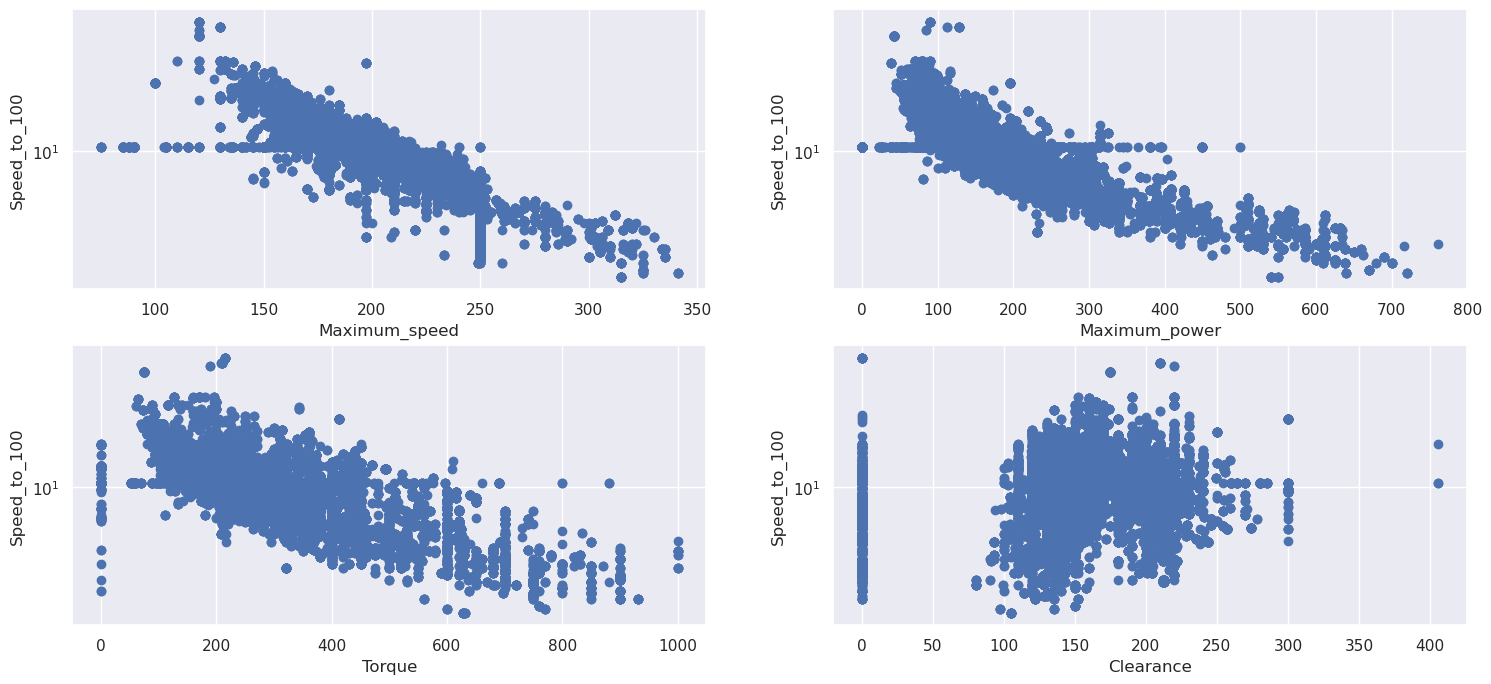

In [189]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
for i, feature in enumerate(['Maximum_speed', 'Maximum_power', 'Torque', 'Clearance']):
    axs[(i+2)//4, i%2].scatter(df[feature], df.Speed_to_100)
    axs[(i+2)//4, i%2].set_xlabel(feature)
    axs[(i+2)//4, i%2].set_ylabel("Speed_to_100")
    axs[(i+2)//4, i%2].set(yscale="log")

In [190]:
%%R
print(cor.test(df$Price, df$Torque, method = 'pearson'))
print(cor.test(df$Price, df$Year, method = 'pearson'))


	Pearson's product-moment correlation

data:  df$Price and df$Torque
t = 145.54, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6171428 0.6302740
sample estimates:
      cor 
0.6237524 


	Pearson's product-moment correlation

data:  df$Price and df$Year
t = 60.668, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3059351 0.3252868
sample estimates:
      cor 
0.3156437 



## Корреляция Спирмена.

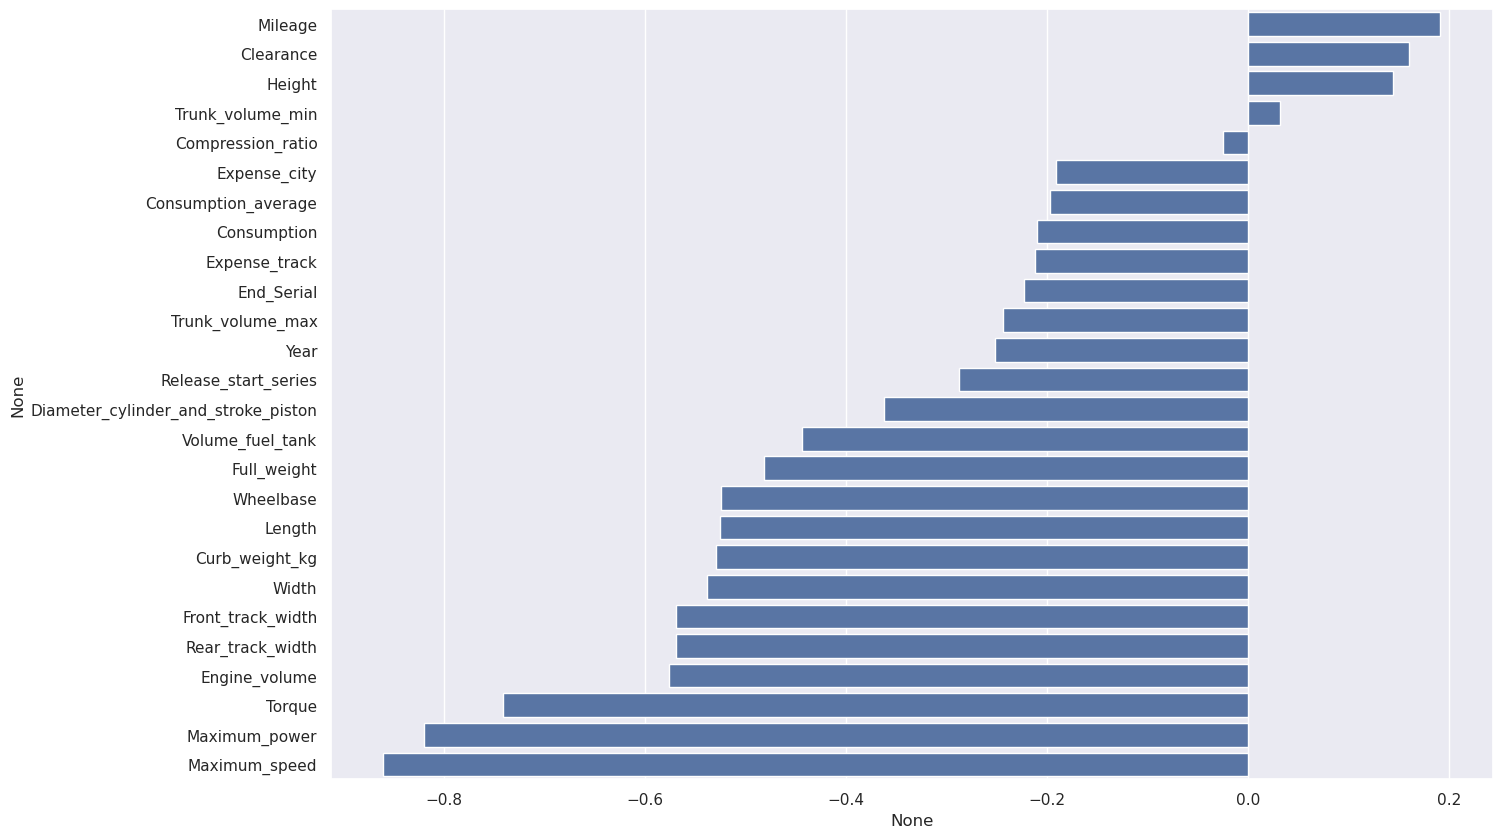

In [191]:
correlations_pirson = df[numeric_features].corrwith(df.Speed_to_100, method='spearman').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [192]:
%%R
print(cor.test(df$Price, df$Torque, method = 'spearman'))
print(cor.test(df$Price, df$Year, method = 'spearman'))


	Spearman's rank correlation rho

data:  df$Price and df$Torque
S = 1.8475e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6988266 


	Spearman's rank correlation rho

data:  df$Price and df$Year
S = 1.6307e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.734174 



In addition: Warning messages:
1: In cor.test.default(df$Price, df$Torque, method = "spearman") :
  Cannot compute exact p-value with ties
2: In cor.test.default(df$Price, df$Year, method = "spearman") :
  Cannot compute exact p-value with ties


## Корреляция Кендалла.

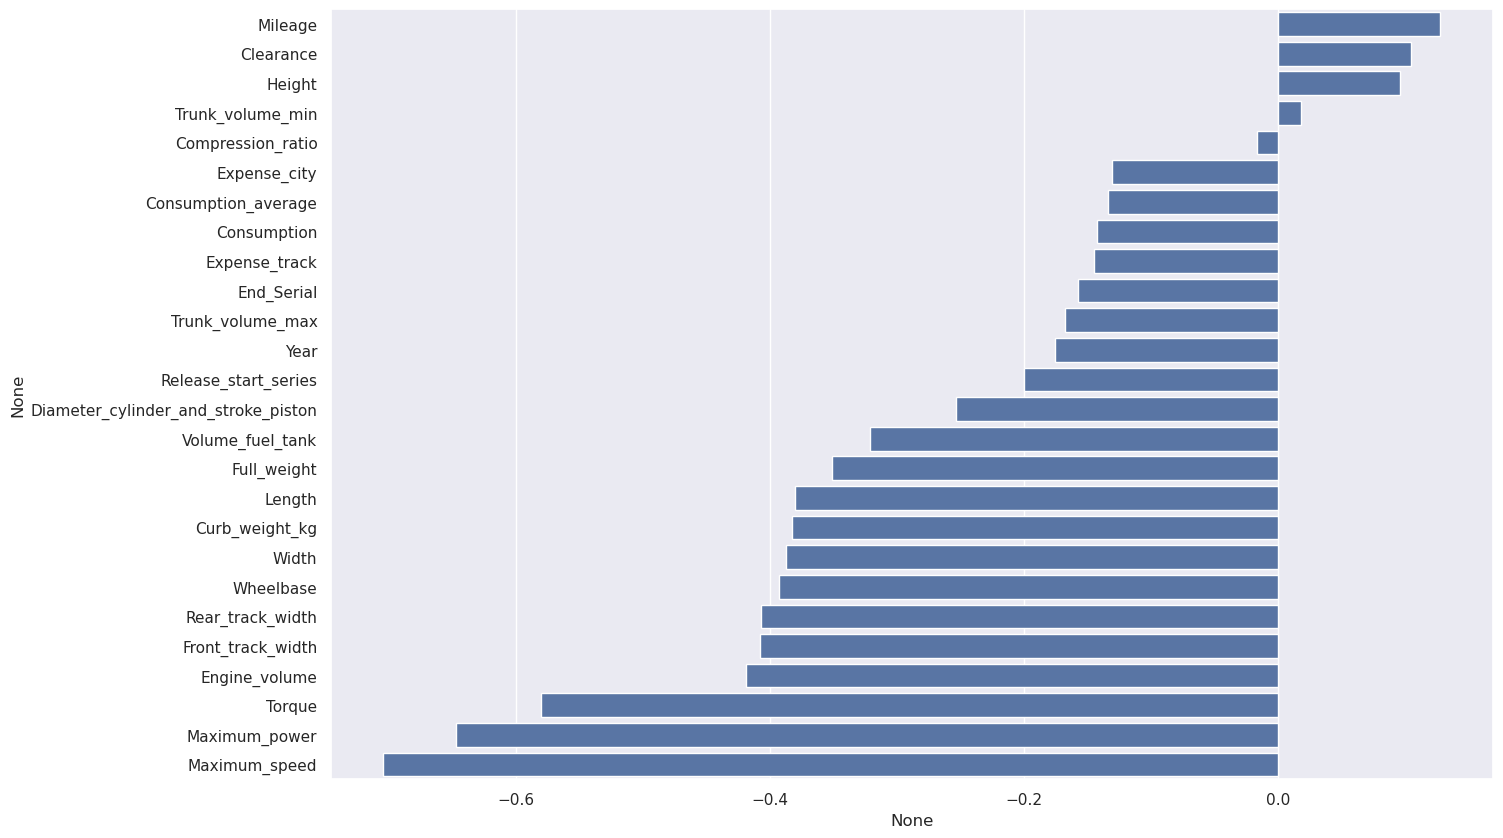

In [193]:
correlations_pirson = df[numeric_features].corrwith(df.Speed_to_100, method='kendall').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [194]:
%%R
print(cor.test(df$Price, df$Torque, method = 'kendall'))
print(cor.test(df$Price, df$Year, method = 'kendall'))


	Kendall's rank correlation tau

data:  df$Price and df$Torque
z = 139.29, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5122107 


	Kendall's rank correlation tau

data:  df$Price and df$Year
z = 149.07, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5595668 



# 9. Использование методов хи-квадрат, точного теста Фишера, теста МакНемара, Кохрана-Мантеля-Хензеля.

## Хи-квадрат

### Возьмём цены на автомобили марки BMW и Mercedes-Benz, разобьём выборки на 5 частей и проверим гипотезу об однородности выборок.

In [195]:
df_bmw_mer_chi = df.loc[(df.mark == "BMW") | (df.mark == "Mercedes-Benz"), ["mark", "Price"]].dropna()

quantileis = [0] * 5
for i in range(0,5):
    quantileis[i] = np.quantile(df_bmw_mer_chi.Price.values, 0.2 * (i+1))

def get_group(x):
    for i in range(5):
        if x < quantileis[i]:
            return i
    return i

df_bmw_mer_chi.Price = df_bmw_mer_chi.Price.apply(get_group)
table = pd.crosstab(
    df_bmw_mer_chi['mark'],
    df_bmw_mer_chi["Price"],
    margins = True
)
table

Price            0    1    2    3    4   All
mark                                        
BMW            439  400  486  461  438  2224
Mercedes-Benz  445  485  399  423  447  2199
All            884  885  885  884  885  4423

In [196]:
from scipy.stats import chi2_contingency
chi, p_value, k, _ = chi2_contingency(table.iloc[:-1, :-1].values)
print(f"{chi = }, {p_value = }")

chi = 18.341396918252144, p_value = 0.0010581982586809855


### Видим, что на любом разумном уровне значимости гипотеза отвергается.

### Проверим аналогичную гипотезу для автомобилей с рестайлингом и без.

In [197]:
df_res_chi = df.loc[:, ["Restyling", "Price"]].dropna()

quantileis = [0] * 5
for i in range(0,5):
    quantileis[i] = np.quantile(df_res_chi.Price.values, 0.2 * (i+1))
    
df_res_chi.Price = df_res_chi.Price.apply(get_group)
table = pd.crosstab(
    df_res_chi['Restyling'],
    df_res_chi["Price"],
    margins = True
)
table

Price         0     1     2     3     4    All
Restyling                                     
0.0        4948  4135  3969  3756  4478  21286
1.0        1679  2540  2672  2895  2192  11978
All        6627  6675  6641  6651  6670  33264

In [198]:
chi, p_value, k, _ = chi2_contingency(table.iloc[:-1, :-1].values)
print(f"{chi = }, {p_value = }")

chi = 582.984962724635, p_value = 7.456560310763358e-125


### Гипотеза отверглась.

## Точный тест Фишера

### Проверим есть ли зависимость между boost_type и расположением цилиндров.

In [199]:
df.loc[df.Boost_type != "no", ["Boost_type", "Cylinder_location"]].groupby(["Boost_type", "Cylinder_location"]).size()

Boost_type     Cylinder_location
compressor     V-type                193
               in-line                86
turbocharging  V-type               2481
               W-type                 91
               in-line              9676
               opposed                87
               rotor                   3
dtype: int64

In [200]:
stats.fisher_exact([[193, 2481], [86, 9676]])

SignificanceResult(statistic=8.752416036294443, pvalue=7.13725548592651e-67)

In [201]:
%%R
fisher.test(matrix(c(193, 2481, 86, 9676), nrow = 2))


	Fisher's Exact Test for Count Data

data:  matrix(c(193, 2481, 86, 9676), nrow = 2)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  6.725204 11.466076
sample estimates:
odds ratio 
   8.75032 



### Гипотеза отверглась, зависимость есть.

### Проверим есть ли зависимость между каробкой передач (механика или автомат) и бензином (АИ-92 или АИ-95).

In [202]:
df.loc[((df.Fuel == "AI-92") | (df.Fuel == "AI-95")) & ((df.Box == "automatic") | (df.Box == "mechanics")),\
       ["Box", "Fuel"]].groupby(["Box", "Fuel"]).size()

Box        Fuel 
automatic  AI-92     1442
           AI-95    12169
mechanics  AI-92     1343
           AI-95     5990
dtype: int64

In [203]:
stats.fisher_exact([[1343, 1442], [5990, 12169]])

SignificanceResult(statistic=1.8920770632515125, pvalue=1.4421186396612848e-53)

In [204]:
%%R
fisher.test(matrix(c(1343, 1442, 5990, 12169), nrow = 2))


	Fisher's Exact Test for Count Data

data:  matrix(c(1343, 1442, 5990, 12169), nrow = 2)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.744156 2.052281
sample estimates:
odds ratio 
  1.892071 



In [205]:
print("Процент автомобилей на АИ-92:\nАвтомат", 1442 / 12169, "\nМеханика:", 1343 / 5990)

Процент автомобилей на АИ-92:
Автомат 0.11849782233544252 
Механика: 0.22420701168614357


### Гипотеза отвергается. Зависимость всё-таки есть. На механике в два раза больше автомобилей на АИ-92 (в процентном соотношении).

### Проведём тесты МакНемара и Кохрана-Мантеля-Хензеля на тех же данных. Увидим, что он тоже отверг гипотезы H0.

In [206]:
from statsmodels.stats.contingency_tables import mcnemar
print(mcnemar([[193, 2481], [86, 9676]], exact=False))

pvalue      0.0
statistic   2232.6591351772495


In [207]:
%%R
mcnemar.test(matrix(c(193, 2481, 86, 9676), nrow = 2))


	McNemar's Chi-squared test with continuity correction

data:  matrix(c(193, 2481, 86, 9676), nrow = 2)
McNemar's chi-squared = 2232.7, df = 1, p-value < 2.2e-16



In [208]:
print(mcnemar([[1343, 1442], [5990, 12169]], exact=False))

pvalue      0.0
statistic   2781.917249730893


In [209]:
%%R
mcnemar.test(matrix(c(1343, 1442, 5990, 12169), nrow = 2))


	McNemar's Chi-squared test with continuity correction

data:  matrix(c(1343, 1442, 5990, 12169), nrow = 2)
McNemar's chi-squared = 2781.9, df = 1, p-value < 2.2e-16



# 10. Проверка наличия мультиколлинеарности в данных с помощью корреляционной матрицы и фактора инфляции дисперсии.

## Построим корреляционную матрицу

In [210]:
num_df = df[numeric_features]

Loading required package: ggplot2
Need help getting started? Try the R Graphics Cookbook:
https://r-graphics.org


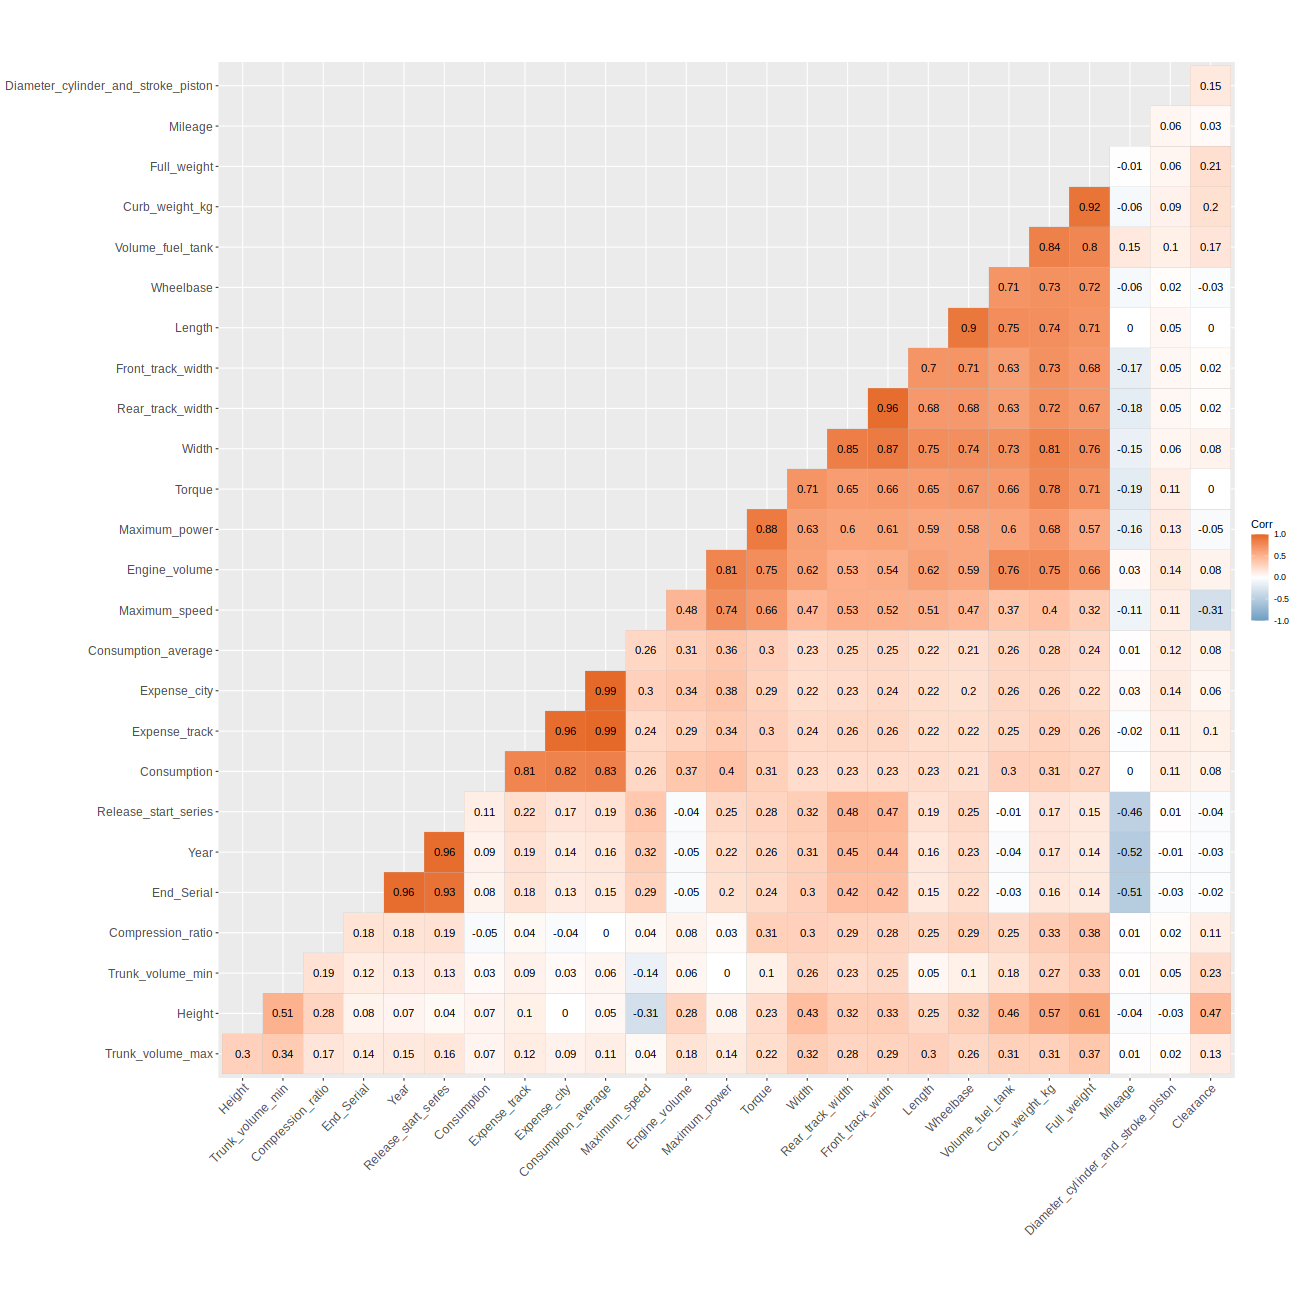

In [211]:
%%R -i num_df -w 1300 -h 1300
library (ggcorrplot)
ggcorrplot(cor(num_df), hc.order = TRUE, lab = TRUE, ggtheme = ggplot2::theme_gray,
           colors = c("#6D9EC1", "white", "#E46726"), type = "lower", insig = "blank")

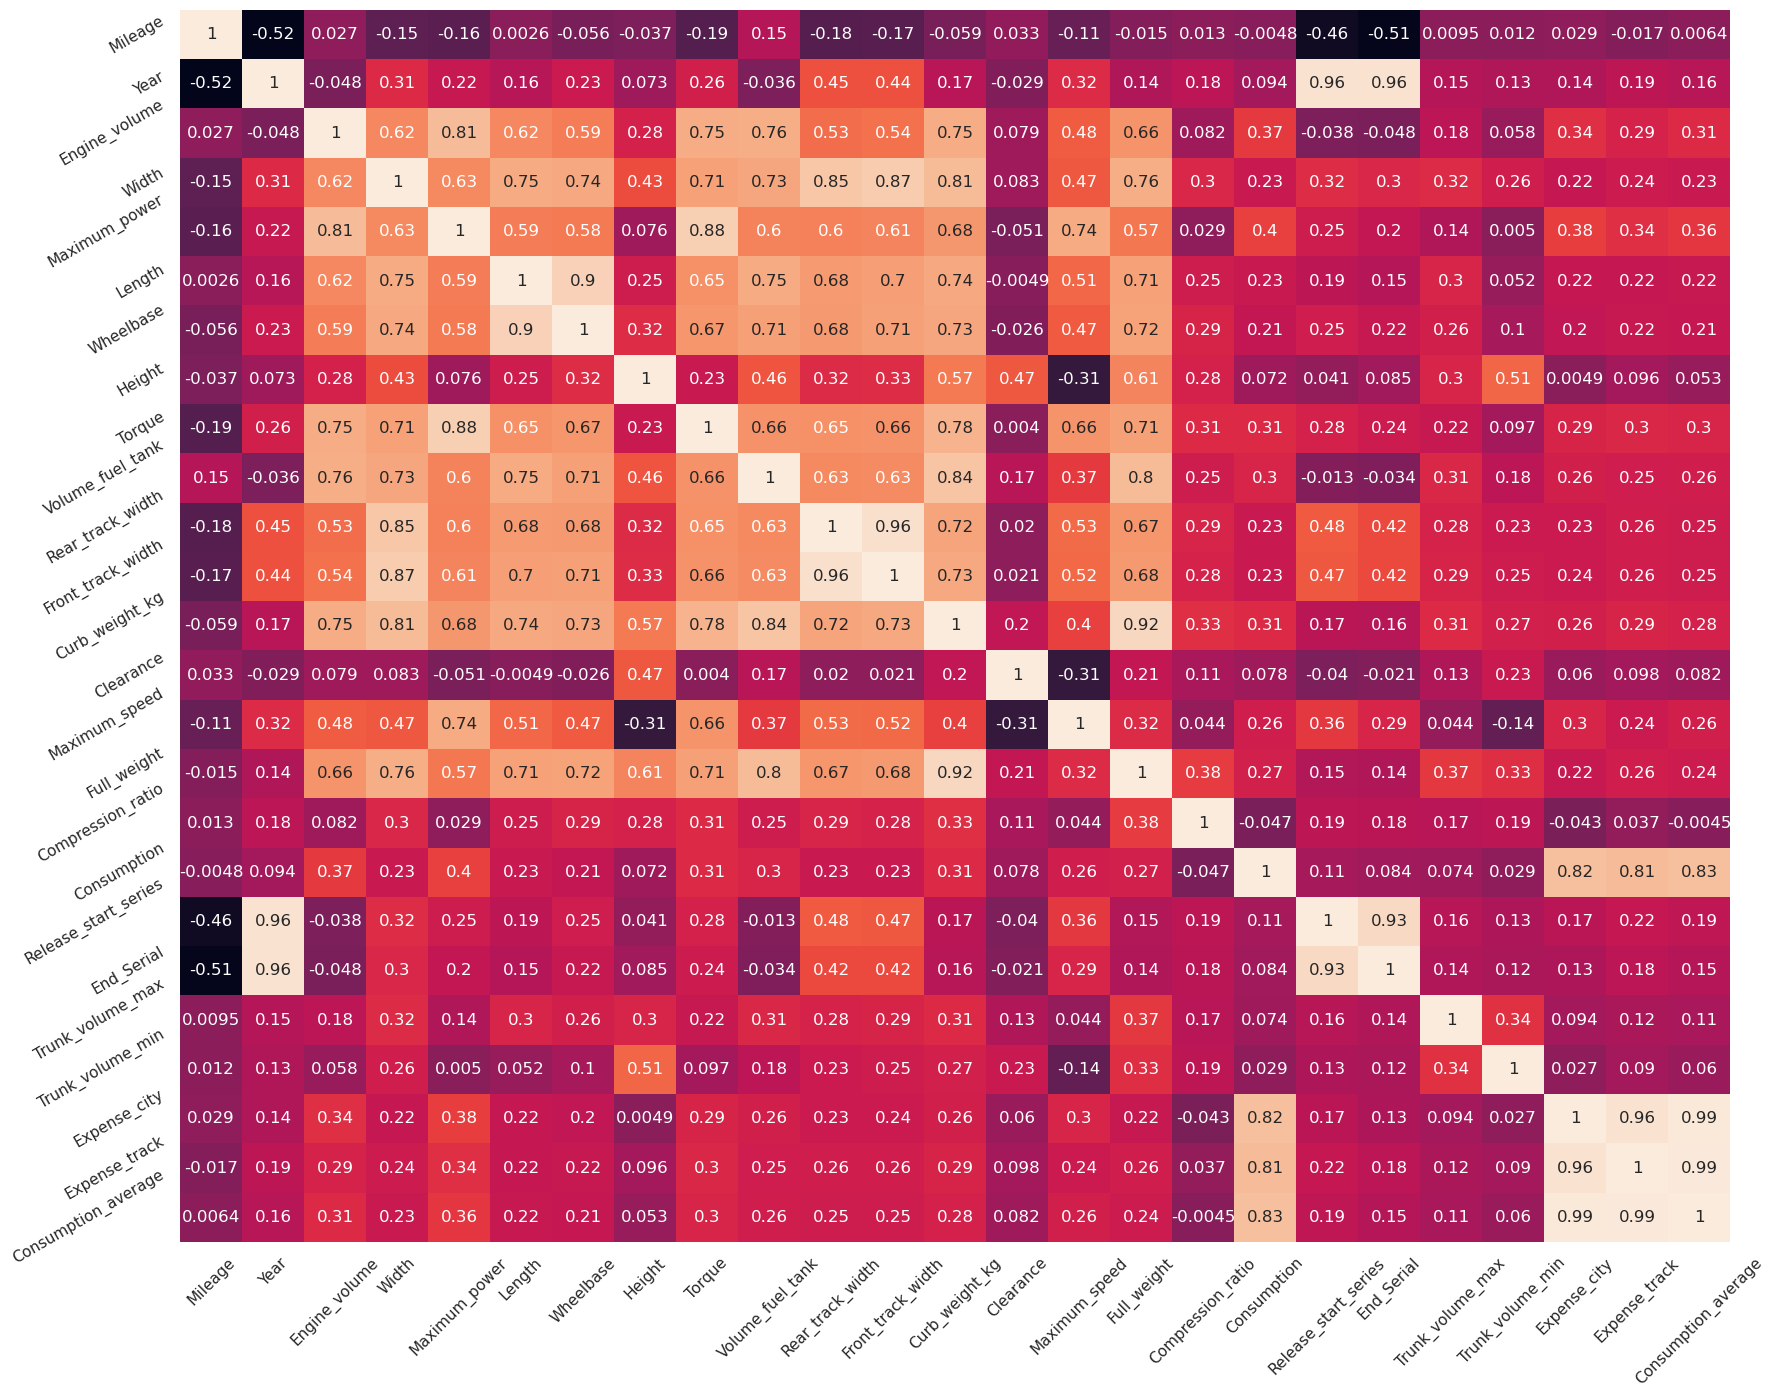

In [212]:
fig, ax = plt.subplots(figsize=(20, 16))
ax = sns.heatmap(data = df[numeric_features].drop("Diameter_cylinder_and_stroke_piston",\
            axis=1).corr(), ax=ax, cbar=False, annot=True)
plt.tick_params(axis='y', which='major', rotation=30)
plt.tick_params(axis='x', which='major', rotation=45)

### На матрице видны следующие мультиколлинеарные зависимости:
+ **Год выпуска, год релиза серии и год конца выпуска (Year, Release_start_series, End_Serial)**
+ **Расход, средний расход, расход на треке и расход по городу (Consumption, Consumption_average, Expense_track, Expense_city)**
+ **Ширина передней и задней колеи с шириной автомобиля (Rear_track_width, Front_track_width, Width)**
+ **Полный вес и Снаряжённая масса (Full_weight, Curb_weight_kg)**
+ **Ширина шины и диаметр обода колеса (Tire_width, "Wheel_diametr")**

## Посмотрим на фактор инфляции дисперсии.

In [213]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df[numeric_features])  
vif = pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(vif)

const                                  146074.178580
Mileage                                     1.694234
Year                                       24.796214
Engine_volume                               5.947117
Width                                       6.319623
Diameter_cylinder_and_stroke_piston         1.098344
Maximum_power                              12.330394
Length                                      7.465154
Wheelbase                                   6.498403
Height                                      4.495754
Torque                                     10.058341
Volume_fuel_tank                            5.574328
Rear_track_width                           13.334713
Front_track_width                          14.622148
Curb_weight_kg                             12.048540
Clearance                                   1.487829
Maximum_speed                               4.953667
Full_weight                                 8.054361
Compression_ratio                           1.

### С учётом всех замечаний выше удалим часть признаков и посмотрим ещё раз на vif.

In [214]:
X.drop(["Front_track_width", "Consumption_average", "Expense_track", "Full_weight", "Release_start_series",\
        "End_Serial"], axis=1, inplace=True)

In [215]:
vif = pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(vif)

const                                  127686.716380
Mileage                                     1.658586
Year                                        2.369105
Engine_volume                               5.627297
Width                                       5.844697
Diameter_cylinder_and_stroke_piston         1.090524
Maximum_power                              11.964474
Length                                      7.424615
Wheelbase                                   6.336566
Height                                      4.255527
Torque                                      9.239696
Volume_fuel_tank                            5.501119
Rear_track_width                            4.838544
Curb_weight_kg                              8.637848
Clearance                                   1.484090
Maximum_speed                               4.837113
Compression_ratio                           1.751883
Consumption                                 3.285155
Trunk_volume_max                            1.

### Видим, что мультиколлинеарность стала гораздо ниже.

# 11. Исследование зависимости в данных с помощью дисперсионного анализа.

## Однофакторный дисперсионный анализ.

### Проверим гипотезу о том, что средняя цена на автомобиль одинакова для автомобилей с разным количеством дверей. 

In [216]:
from scipy.stats import f_oneway

In [217]:
doors5 = df.loc[df.Doors == 5, "Price"]
doors4 = df.loc[df.Doors == 4, "Price"]
doors3 = df.loc[df.Doors == 3, "Price"]
doors2 = df.loc[df.Doors == 2, "Price"]
f_oneway(doors2, doors3, doors4, doors5)

F_onewayResult(statistic=302.13383914574194, pvalue=1.5399777367608037e-193)

In [218]:
%%R
summary(aov(df$Doors ~ df$Price))

               Df Sum Sq Mean Sq F value Pr(>F)    
df$Price        1     72   71.86   116.5 <2e-16 ***
Residuals   33262  20515    0.62                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Эта гипотезы отверглась,  так как у спорткаров количество дверей меньше, а цена их выше.

### Средние цены на автомобиль с рестайлингом и без одинаковы:

In [219]:
rest0 = df.loc[df.Restyling == 0, "Price"]
rest1 = df.loc[df.Restyling == 1, "Price"]
stats.f_oneway(rest0, rest1)

F_onewayResult(statistic=6.864821301618504, pvalue=0.008794896870266657)

In [220]:
%%R
summary(aov(df$Restyling ~ df$Price))

               Df Sum Sq Mean Sq F value  Pr(>F)   
df$Price        1      2  1.5816   6.865 0.00879 **
Residuals   33262   7663  0.2304                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [221]:
rest0.mean(), rest1.mean()

(1552872.6481255286, 1477609.1215561864)

### Отвергаем эту гипотезу на любом разумном уровне значимости.

### Средняя максимальная мощность не зависит от топлива. 

In [222]:
df_without_nans = df.loc[df.Fuel.notna() & df.Maximum_power.notna(), ["Fuel", "Maximum_power"]]

In [223]:
%%R -i df_without_nans
summary(aov(df_without_nans$Maximum_power ~ df_without_nans$Fuel))

                        Df   Sum Sq  Mean Sq F value Pr(>F)    
df_without_nans$Fuel     6 1.01e+08 16832919    2199 <2e-16 ***
Residuals            32794 2.51e+08     7654                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Посмотрим, может она одинакова у АИ-95 и АИ-92.

In [224]:
df.Fuel.value_counts()

Fuel
AI-95     22554
diesel     5209
AI-92      3262
AI-98      1458
AI-80       255
AI-76        61
GAZ           2
Name: count, dtype: int64

In [225]:
fuel95 = df.loc[df.Fuel == "AI-95", "Maximum_power"]
fuel92 = df.loc[df.Fuel == "AI-92", "Maximum_power"]
stats.f_oneway(fuel95, fuel92)

F_onewayResult(statistic=242.4131313553884, pvalue=2.0710793132154393e-54)

### Обе гипотезы отвергаются на любом разумном уровне значимости.

## Двухфакторный дисперсионный анализ.

In [226]:
categorical_features

array(['Box', 'Drive_unit', 'Seats', 'Doors', 'Engine', 'Car_type',
       'Drive', 'Boost_type', 'Cylinder_location', 'Front_brakes',
       'Front_Suspension_type', 'Car_class', 'Cylinders', 'Fuel',
       'Valves_per_cylinder', 'Engine_Location', 'Transmissions',
       'Engine_Power', 'Restyling', 'Tire_width', 'Aspect_ratio',
       'Wheel_diametr'], dtype=object)

In [227]:
%%R
A <- lm(df$Maximum_power ~ df$Fuel*df$Transmissions)
summary(A)
anova(A)

Analysis of Variance Table

Response: df$Maximum_power
                            Df    Sum Sq  Mean Sq  F value    Pr(>F)    
df$Fuel                      6 100997512 16832919  2995.43 < 2.2e-16 ***
df$Transmissions             1  63518533 63518533 11303.18 < 2.2e-16 ***
df$Fuel:df$Transmissions     5   3225009   645002   114.78 < 2.2e-16 ***
Residuals                32788 184253084     5620                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Трёхфакторный дисперсионный анализ.

In [228]:
%%R
A <- lm(df$Maximum_power ~ df$Fuel*df$Transmissions*df$Car_class)
summary(A)
anova(A)

Analysis of Variance Table

Response: df$Maximum_power
                                         Df    Sum Sq  Mean Sq    F value
df$Fuel                                   6 100346228 16724371  4534.3421
df$Transmissions                          1  61467077 61467077 16665.0663
df$Car_class                              8  54050601  6756325  1831.7872
df$Fuel:df$Transmissions                  5   2440218   488044   132.3193
df$Fuel:df$Car_class                     32   4813307   150416    40.7810
df$Transmissions:df$Car_class             8   3646343   455793   123.5754
df$Fuel:df$Transmissions:df$Car_class    26    911387    35053     9.5037
Residuals                             32452 119695268     3688           
                                         Pr(>F)    
df$Fuel                               < 2.2e-16 ***
df$Transmissions                      < 2.2e-16 ***
df$Car_class                          < 2.2e-16 ***
df$Fuel:df$Transmissions              < 2.2e-16 ***
df$Fuel:df$Car_clas

### Выводы видны в таблицах. Все гипотезы отверглись на любом разумном уровне значимости.

# 12. Регрессионные модели.

### Разделим признаки на категориальные и количественные.

In [246]:
numeric_features = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].drop(['Price',\
        'Speed_to_100', 'Cylinders', 'Transmissions', "Seats", "Doors", "Restyling", "Electric_car",\
        "Volume", "Valves_per_cylinder", "Tire_width", "Aspect_ratio", "Wheel_diametr"]).index.values
categorical_features = df.dtypes[(df.dtypes == 'object') | (df.dtypes.index.isin(['Cylinders',\
    'Transmissions', "Seats", "Doors", "Restyling", "Valves_per_cylinder", "Tire_width",\
    "Aspect_ratio", "Wheel_diametr"]))].drop(['mark', 'Country', 'Color',\
    'Generation', 'Model']).index.values

### Будем предсказывать цену на автомобиль и его время разгона до 100 км/ч. Разделим выборку на train и test.

In [247]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Price", "Speed_to_100"], axis=1),\
                                    df[["Price", "Speed_to_100"]], test_size=0.2, random_state=2005)

## Заполнение пропусков для количественных признаков.

### Посмотрим есть ли у нас NAN в количественных признаках:

In [248]:
df[numeric_features].isna().sum()

Mileage                                0
Year                                   0
Engine_volume                          0
Width                                  0
Diameter_cylinder_and_stroke_piston    0
Maximum_power                          0
Length                                 0
Wheelbase                              0
Height                                 0
Torque                                 0
Volume_fuel_tank                       0
Rear_track_width                       0
Front_track_width                      0
Curb_weight_kg                         0
Clearance                              0
Maximum_speed                          0
Full_weight                            0
Compression_ratio                      0
Consumption                            0
Release_start_series                   0
End_Serial                             0
Trunk_volume_max                       0
Trunk_volume_min                       0
Expense_city                           0
Expense_track   

### NAN-ов нет посмотрим на нули:

In [249]:
zeros_cheak = (df[np.delete(numeric_features, [np.where(numeric_features == "Mileage")[0][0]])] == 0).sum()
features_with_zeros = zeros_cheak[zeros_cheak > 0].index
zeros_cheak

Year                                       0
Engine_volume                              0
Width                                      0
Diameter_cylinder_and_stroke_piston     3656
Maximum_power                            191
Length                                     0
Wheelbase                                  0
Height                                     0
Torque                                   457
Volume_fuel_tank                           0
Rear_track_width                           0
Front_track_width                          0
Curb_weight_kg                             0
Clearance                               1739
Maximum_speed                              0
Full_weight                                0
Compression_ratio                          0
Consumption                             3955
Release_start_series                       0
End_Serial                                 0
Trunk_volume_max                        1941
Trunk_volume_min                       14227
Expense_ci

In [250]:
features_with_zeros

Index(['Diameter_cylinder_and_stroke_piston', 'Maximum_power', 'Torque',
       'Clearance', 'Consumption', 'Trunk_volume_max', 'Trunk_volume_min',
       'Expense_city', 'Expense_track', 'Consumption_average'],
      dtype='object')

### Удалим признаки Trunk_volume_min, Expense_city, Expense_track, Consumption_average, Trunk_volume_max, Diameter_cylinder_and_stroke_piston так как они имеют большое количество пропусков, плюс 8-ой пункт показал что они достаточно неинформативные.

In [251]:
X_train.drop(["Trunk_volume_min", "Expense_city", "Expense_track", "Consumption_average",\
              "Trunk_volume_max", "Diameter_cylinder_and_stroke_piston"], axis=1, inplace=True)
X_test.drop(["Trunk_volume_min", "Expense_city", "Expense_track", "Consumption_average",\
              "Trunk_volume_max", "Diameter_cylinder_and_stroke_piston"], axis=1, inplace=True)

In [252]:
features_with_zeros = list(features_with_zeros)
numeric_features = list(numeric_features)
for feature in (["Trunk_volume_min", "Expense_city", "Expense_track", "Consumption_average",\
              "Trunk_volume_max", "Diameter_cylinder_and_stroke_piston"]):
    features_with_zeros.remove(feature)
    numeric_features.remove(feature)

### Для признаков Maximum_power, Torque, Clearance, Consumption удалим нулевые значения. В тестовой выборке их заполним медианами, расчитанными по тренировочной выборке.

In [253]:
indeces_to_drop = set()
for feature in features_with_zeros:
    indeces_to_drop.update(X_train.loc[:, feature][X_train.loc[:, feature] == 0].index)
indeces_to_drop = list(indeces_to_drop)
X_train.drop(indeces_to_drop, inplace=True)
y_train.drop(indeces_to_drop, inplace=True)

In [254]:
for feature in features_with_zeros:
    X_test.loc[X_test[feature] == 0, feature] = X_train[feature].median()

## Заполнение пропусков для категориальных признаков.

In [255]:
df[categorical_features].isna().sum()

Box                         0
Drive_unit                  0
Seats                       0
Doors                       0
Engine                      0
Car_type                    0
Drive                     191
Boost_type                320
Cylinder_location         279
Front_brakes              191
Front_Suspension_type     191
Car_class                 299
Cylinders                   0
Fuel                      463
Valves_per_cylinder         0
Engine_Location          1431
Transmissions               0
Engine_Power             5409
Restyling                   0
Tire_width                  0
Aspect_ratio                0
Wheel_diametr               0
dtype: int64

In [256]:
features_with_nans = df[categorical_features].isna().sum()[df[categorical_features].isna().sum() > 0].index

### Удалим признак Engine_Power, у остальных признаков удалим пропуски. В тестовой выборке пропуски заполним модами.

In [257]:
X_train.drop(["Engine_Power"], axis=1, inplace=True)
X_test.drop(["Engine_Power"], axis=1, inplace=True)

categorical_features = list(categorical_features)
features_with_nans = list(features_with_nans)
features_with_nans.remove("Engine_Power")
categorical_features.remove("Engine_Power")

In [258]:
indeces_to_drop = set()
for feature in features_with_nans:
    indeces_to_drop.update(X_train[feature][X_train[feature].isna()].index)
indeces_to_drop = list(indeces_to_drop)
X_train.drop(indeces_to_drop, inplace=True)
y_train.drop(indeces_to_drop, inplace=True)

In [259]:
for feature in features_with_nans:
    X_train.loc[X_train[feature].isna(), feature] = X_train[feature].mode()[0]
    X_test.loc[X_test[feature].isna(), feature] = X_train[feature].mode()[0]

### Посмотрим в каких категориальных признаках встречаются нули.

In [260]:
cat_num_features = df[categorical_features].dtypes[(df[categorical_features].dtypes == "float64") |\
                (df[categorical_features].dtypes == "int64")].index
(df[cat_num_features] == 0).sum()

Seats                      0
Doors                      9
Cylinders                 88
Valves_per_cylinder        0
Transmissions              0
Restyling              21286
Tire_width              1540
Aspect_ratio            1540
Wheel_diametr           1540
dtype: int64

In [261]:
cat_num_features

Index(['Seats', 'Doors', 'Cylinders', 'Valves_per_cylinder', 'Transmissions',
       'Restyling', 'Tire_width', 'Aspect_ratio', 'Wheel_diametr'],
      dtype='object')

### Удалим пропуски в Tire_width, Aspect_ratio, Wheel_diametr, Doors, Cylinders.

In [262]:
indeces_to_drop = set()
for feature in ["Tire_width", "Aspect_ratio", "Wheel_diametr", "Doors", "Cylinders"]:
    indeces_to_drop.update(X_train.loc[X_train[feature] == 0, feature].index)
indeces_to_drop = list(indeces_to_drop)
X_train.drop(indeces_to_drop, inplace=True)
y_train.drop(indeces_to_drop, inplace=True)

In [263]:
for feature in (["Tire_width", "Aspect_ratio", "Wheel_diametr", "Doors", "Cylinders"]):
    X_test.loc[X_test[feature] == 0, feature] = X_train[feature].mode()[0]

### Проверим, что наши данные чисты.

In [264]:
(X_train.isna().sum() != 0).sum(), (X_test.isna().sum() != 0).sum()

(0, 0)

In [265]:
(X_train[numeric_features] == 0).sum()

Mileage                 1857
Year                       0
Engine_volume              0
Width                      0
Maximum_power              0
Length                     0
Wheelbase                  0
Height                     0
Torque                     0
Volume_fuel_tank           0
Rear_track_width           0
Front_track_width          0
Curb_weight_kg             0
Clearance                  0
Maximum_speed              0
Full_weight                0
Compression_ratio          0
Consumption                0
Release_start_series       0
End_Serial                 0
dtype: int64

In [266]:
(X_test[numeric_features] == 0).sum()

Mileage                 590
Year                      0
Engine_volume             0
Width                     0
Maximum_power             0
Length                    0
Wheelbase                 0
Height                    0
Torque                    0
Volume_fuel_tank          0
Rear_track_width          0
Front_track_width         0
Curb_weight_kg            0
Clearance                 0
Maximum_speed             0
Full_weight               0
Compression_ratio         0
Consumption               0
Release_start_series      0
End_Serial                0
dtype: int64

In [267]:
(X_train[cat_num_features] == 0).sum()

Seats                      0
Doors                      0
Cylinders                  0
Valves_per_cylinder        0
Transmissions              0
Restyling              12892
Tire_width                 0
Aspect_ratio               0
Wheel_diametr              0
dtype: int64

In [268]:
(X_test[cat_num_features] == 0).sum()

Seats                     0
Doors                     0
Cylinders                 0
Valves_per_cylinder       0
Transmissions             0
Restyling              4210
Tire_width                0
Aspect_ratio              0
Wheel_diametr             0
dtype: int64

In [269]:
features = np.concatenate((numeric_features, categorical_features))

### Посмотрим какого размера получились данные.

In [270]:
X_train.shape, X_test.shape

((20939, 48), (6653, 48))

## Обработка данных завершена. Построим линейные модели. Метрика RMSE и R^2.

### Применим Ridge регрессию на количественных признаках.

In [271]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [272]:
model = Ridge()

cv_scores = cross_val_score(model, X_train[numeric_features], y_train.Price, cv=10, scoring="neg_median_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

model.fit(X_train[numeric_features], y_train.Price)
y_train_pred = model.predict(X_train[numeric_features])
y_pred = model.predict(X_test[numeric_features])
print("Train RMSE = %.6f" % mean_squared_error(y_train.Price, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Price, y_pred, squared=False))
print("Train r2 = %.6f" % r2_score(y_train.Price, y_train_pred))
print("Test r2 = %.6f" % r2_score(y_test.Price, y_pred))

Cross validation scores:
	 -431165.5137
	-419792.1367
	-417424.0358
	-392388.4214
	-403666.0632
	-393786.4262
	-403336.0458
	-409008.0864
	-403643.7584
	-428605.7504
Mean CV RMSE = 410281.623805
Train RMSE = 1802335.257601
Test RMSE = 1568572.744655
Train r2 = 0.486319
Test r2 = 0.541975


### Видим, что качество очень плохое, нормируем наши данные.

In [273]:
%%R -i X_train -i X_test -i y_train -i y_test -i numeric_features -i categorical_features
y_train_price <- y_train[, 1]
y_test_price <- y_test[, 1]
y_train_speed_to_100 <- y_train[, 2]
y_test_speed_to_100 <- y_test[, 2]
X_train <- data.matrix(X_train)
X_test <- data.matrix(X_test)

library (glmnet)
library(Metrics)
model <- glmnet(X_train[,numeric_features], y_train_price, alpha = 0 )
y_pred_train <- predict(model, newx = X_train[,numeric_features])
y_pred <- predict(model, newx = X_test[,numeric_features])
print(c("RMSE Train", rmse(y_train_price, y_pred_train)))
print(c("RMSE Test", rmse(y_test_price, y_pred)))

[1] "RMSE Train"       "2157496.91608165"
[1] "RMSE Test"        "1949528.22506431"


Loading required package: Matrix
Loaded glmnet 4.1-8


In [274]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

cv_scores = cross_val_score(model, X_train_scaled, y_train.Price, cv=10, scoring="neg_median_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

model.fit(X_train_scaled, y_train.Price)
y_train_pred = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled)

print("Train RMSE = %.6f" % mean_squared_error(y_train.Price, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Price, y_pred, squared=False))
print("Train r2 = %.6f" % r2_score(y_train.Price, y_train_pred))
print("Test r2 = %.6f" % r2_score(y_test.Price, y_pred))

Cross validation scores:
	 -431165.7479
	-419732.4084
	-417554.4812
	-392663.1613
	-403693.2663
	-393970.5604
	-403115.8899
	-408765.1350
	-403875.9506
	-428585.2262
Mean CV RMSE = 410312.182722
Train RMSE = 1802335.290186
Test RMSE = 1568545.413805
Train r2 = 0.486319
Test r2 = 0.541991


### Посмотрим, на веса, узнаем от каких признаков больше всего зависит целевая переменная.

In [275]:
def show_weights(features, weights, means):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, means), reverse=True)
    weights, features, means = zip(*sorted_weights)
    features = list(features)
    
    sns.barplot(y=features, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    plt.tight_layout()

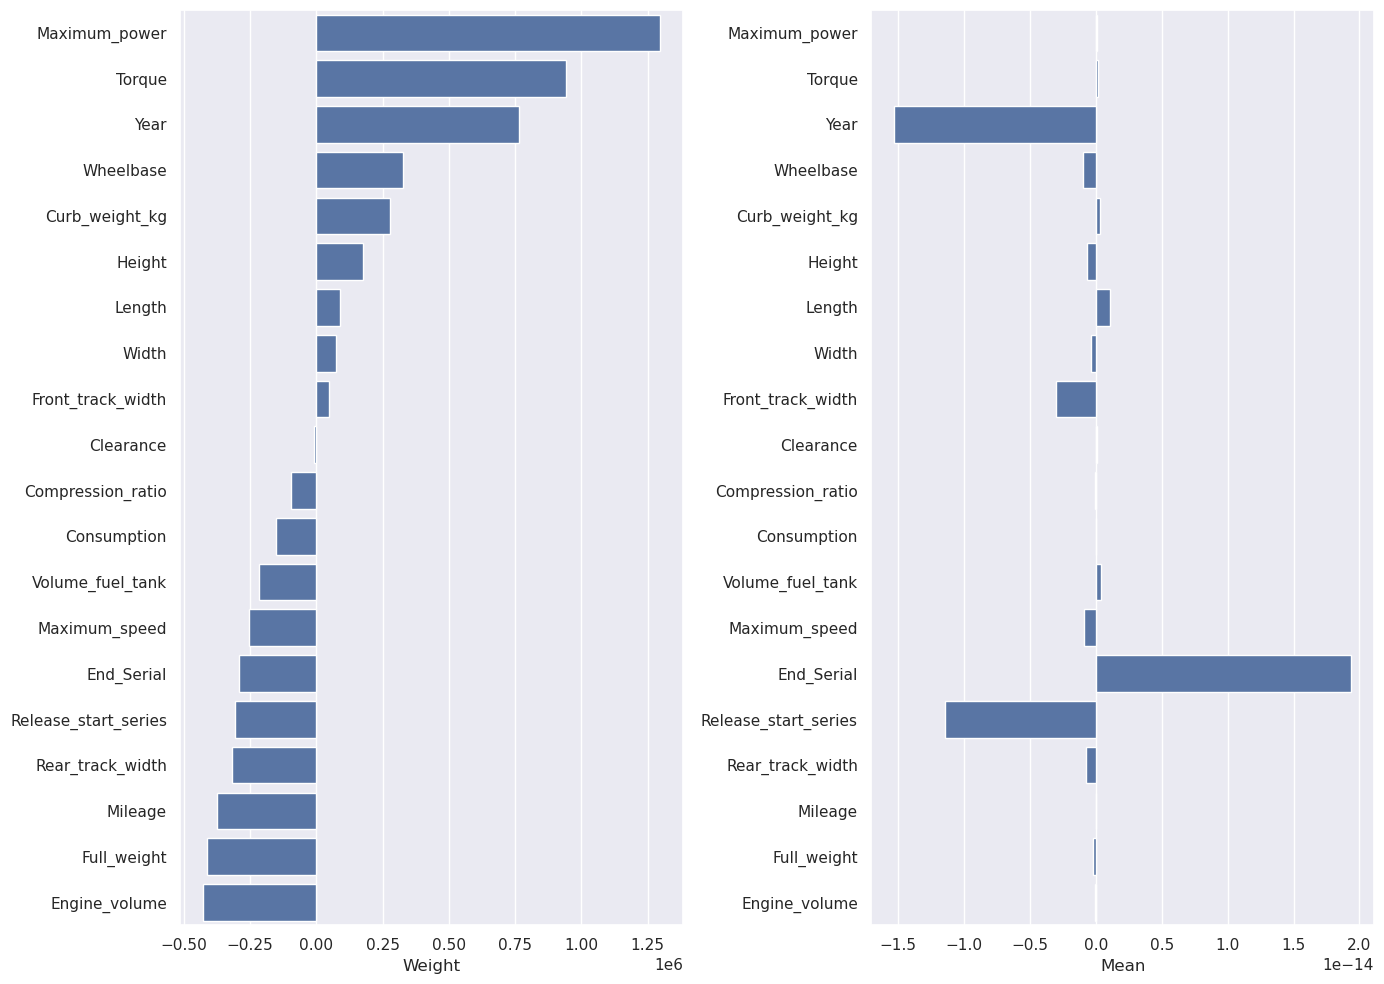

In [276]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, means)

### Добавим категориальные признаки.

In [277]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

cv_scores = cross_val_score(pipeline, X_train[features], y_train, cv=10, scoring="neg_median_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train[features], y_train.Price)
y_train_pred = pipeline.predict(X_train[features])
y_pred = pipeline.predict(X_test[features])
print("Train RMSE = %.6f" % mean_squared_error(y_train.Price, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Price, y_pred, squared=False))
print("Train r2 = %.6f" % r2_score(y_train.Price, y_train_pred))
print("Test r2 = %.6f" % r2_score(y_test.Price, y_pred))

Cross validation scores:
	 -169100.8214
	-168824.2257
	-163401.2217
	-160667.7908
	-164031.2374
	-156954.6544
	-157081.4272
	-162762.6729
	-165062.6913
	-156926.6053
Mean CV RMSE = 162481.334818
Train RMSE = 1543253.740946
Test RMSE = 1397737.126176
Train r2 = 0.623386
Test r2 = 0.636310


### Попробуем также добавить марку автомобиля и страну производитель.

In [278]:
column_transformer = ColumnTransformer([
    ('ohe_for_mark', OneHotEncoder(handle_unknown="ignore"), ["mark"]),
    ('ohe_for_country', OneHotEncoder(handle_unknown="ignore"), ["Country"]),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

cv_scores = cross_val_score(pipeline, X_train, y_train.Price, cv=10, scoring="neg_median_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train, y_train.Price)
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Price, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Price, y_pred, squared=False))
print("Train r2 = %.6f" % r2_score(y_train.Price, y_train_pred))
print("Test r2 = %.6f" % r2_score(y_test.Price, y_pred))

Cross validation scores:
	 -298055.4676
	-309977.9731
	-291999.4076
	-298105.3346
	-302590.0374
	-287679.6593
	-301983.6050
	-277118.6400
	-310968.9151
	-293918.2105
Mean CV RMSE = 297239.725015
Train RMSE = 1465930.310025
Test RMSE = 1366968.454145
Train r2 = 0.660180
Test r2 = 0.652146


### Видим, что качество на тесте увеличилось, тогда как на кросc-валидации упало. Попробуем удалить те объекты, на которых мы очень сильно ошибаемся.

### Посмотрим на то, как увеличилось признаковое пространство:

In [279]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (20939, 48)
Size after OneHot: (20939, 256)


In [280]:
mask = y_train.Price[(y_train.Price < np.quantile(y_train.Price, 0.99))].index

In [281]:
column_transformer = ColumnTransformer([
    ('ohe_for_mark', OneHotEncoder(handle_unknown="ignore"), ["mark"]),
    ('ohe_for_country', OneHotEncoder(handle_unknown="ignore"), ["Country"]),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

cv_scores = cross_val_score(pipeline, X_train.loc[mask, :], y_train.Price[mask], cv=10, scoring="neg_median_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train.loc[mask, :], y_train.Price[mask])
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Price, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Price, y_pred, squared=False))
print("Train r2 = %.6f" % r2_score(y_train.Price, y_train_pred))
print("Test r2 = %.6f" % r2_score(y_test.Price, y_pred))

Cross validation scores:
	 -243164.3740
	-239173.3641
	-234368.2502
	-239792.0183
	-249181.7542
	-240479.5201
	-247911.9167
	-220542.7258
	-237424.9695
	-232430.4799
Mean CV RMSE = 238446.937285
Train RMSE = 1683822.534706
Test RMSE = 1461596.153696
Train r2 = 0.551652
Test r2 = 0.602319


### Качество упало очень сильно. Попробуем подобрать оптимальную константу регуляризации.

Best alpha = 14.3845


Text(0, 0.5, 'CV score')

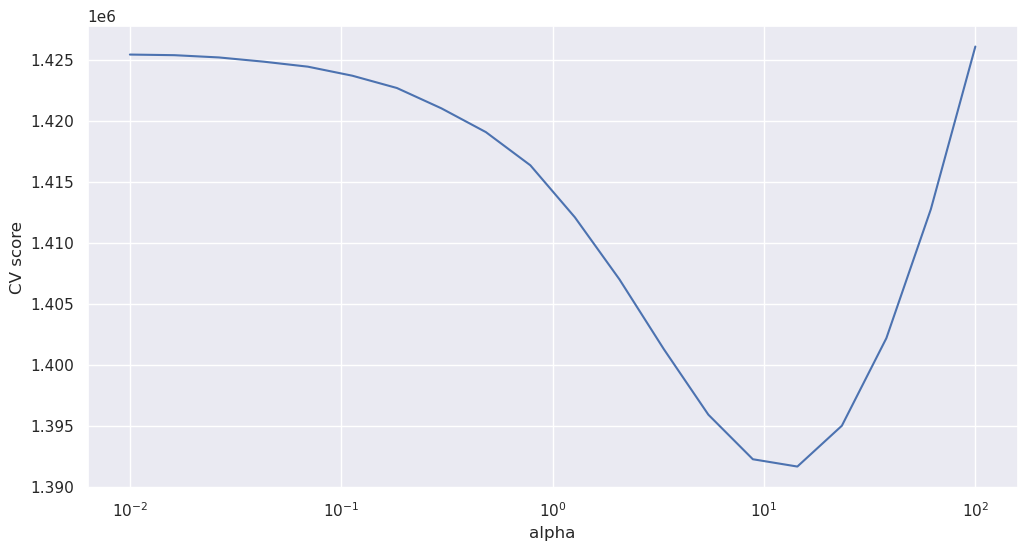

In [282]:
alphas = np.logspace(-2, 2, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train.Price)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

### Обучим модель на лучшей константе регуляризации.

In [283]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

cv_scores = cross_val_score(pipeline, X_train, y_train.Price, cv=10, scoring="neg_median_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train, y_train.Price)
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Price, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Price, y_pred, squared=False))
print("Train r2 = %.6f" % r2_score(y_train.Price, y_train_pred))
print("Test r2 = %.6f" % r2_score(y_test.Price, y_pred))

Cross validation scores:
	 -322504.1406
	-333162.5751
	-309735.7015
	-310776.3041
	-320254.8623
	-300721.6480
	-314394.9105
	-294494.4696
	-319099.3921
	-314082.8004
Mean CV RMSE = 313922.680430
Train RMSE = 1495074.287997
Test RMSE = 1367142.595181
Train r2 = 0.646534
Test r2 = 0.652057


### Вывод: Ошибка очень большая. Цена плохо приближается линейной моделью. 

## Линейная регрессия для Speed_to_100.

In [284]:
model = Ridge()

cv_scores = cross_val_score(model, X_train[numeric_features], y_train.Speed_to_100, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

model.fit(X_train[numeric_features], y_train.Speed_to_100)
y_train_pred = model.predict(X_train[numeric_features])
y_pred = model.predict(X_test[numeric_features])
print("Train RMSE = %.6f" % mean_squared_error(y_train.Speed_to_100, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Speed_to_100, y_pred, squared=False))

Cross validation scores:
	 -1.0801
	-1.1097
	-1.2086
	-1.1781
	-1.1684
	-1.1317
	-1.1028
	-1.0831
	-1.0770
	-1.1273
Mean CV RMSE = 1.126687
Train RMSE = 1.125605
Test RMSE = 1.705377


### Нормируем наши данные и обучим ещё раз.

In [285]:
%%R
model <- glmnet(X_train[,numeric_features], y_train_speed_to_100, alpha = 0 )
y_pred_train <- predict(model, newx = X_train[,numeric_features])
y_pred <- predict(model, newx = X_test[,numeric_features])
print(c("RMSE Train", rmse(y_train_speed_to_100, y_pred_train)))
print(c("RMSE Test", rmse(y_test_speed_to_100, y_pred)))

[1] "RMSE Train"       "2.15082484373075"
[1] "RMSE Test"        "2.48473800804628"


In [286]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

cv_scores = cross_val_score(model, X_train_scaled, y_train.Speed_to_100, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

model.fit(X_train_scaled, y_train.Speed_to_100)
y_train_pred = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Speed_to_100, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Speed_to_100, y_pred, squared=False))

Cross validation scores:
	 -1.0801
	-1.1097
	-1.2086
	-1.1781
	-1.1684
	-1.1317
	-1.1028
	-1.0831
	-1.0770
	-1.1273
Mean CV RMSE = 1.126686
Train RMSE = 1.125605
Test RMSE = 1.705366


### Видим, что метрика осталась той же. Посмотрим, на веса, узнаем от каких признаков больше всего зависит целевая переменная.

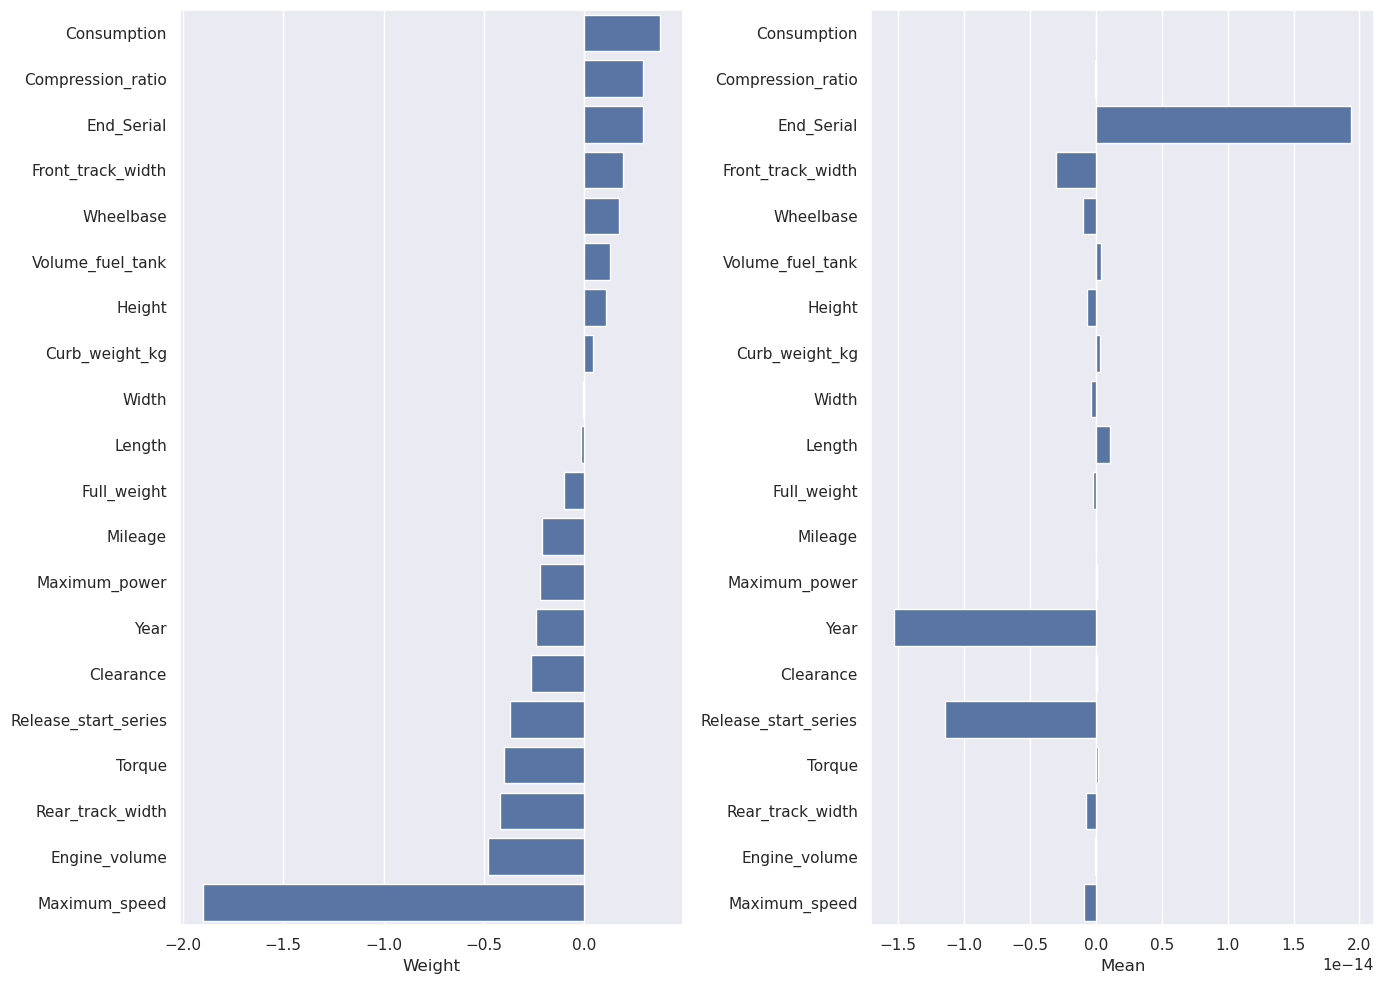

In [287]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, means)

### Добавим категориальные признаки.

In [288]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

cv_scores = cross_val_score(pipeline, X_train, y_train.Speed_to_100, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train, y_train.Speed_to_100)
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Speed_to_100, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Speed_to_100, y_pred, squared=False))

Cross validation scores:
	 -0.8961
	-0.8833
	-1.0474
	-1.0230
	-0.9276
	-0.9151
	-0.8870
	-0.8732
	-0.8866
	-0.9255
Mean CV RMSE = 0.926474
Train RMSE = 0.918194
Test RMSE = 1.685336


### Видим, значительный прирост качества. Добавим к категориальным признакам марку автомобиля и страну производитель.

In [289]:
column_transformer = ColumnTransformer([
    ('ohe_for_mark', OneHotEncoder(handle_unknown="ignore"), ["mark"]),
    ('ohe_for_country', OneHotEncoder(handle_unknown="ignore"), ["Country"]),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

cv_scores = cross_val_score(pipeline, X_train, y_train.Speed_to_100, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train, y_train.Speed_to_100)
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Speed_to_100, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Speed_to_100, y_pred, squared=False))

Cross validation scores:
	 -0.8451
	-0.8210
	-1.0045
	-0.9580
	-0.8695
	-0.8640
	-0.8107
	-0.8142
	-0.8408
	-0.8865
Mean CV RMSE = 0.871423
Train RMSE = 0.856463
Test RMSE = 1.663938


### Стало лучше. Посмотрим сколько у нас теперь признаков после кодирования.

In [290]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (20939, 48)
Size after OneHot: (20939, 256)


### Найдём наилучший коэффициент регуляризации и обучим на нём нашу модель.

Best alpha = 12.7427


Text(0, 0.5, 'CV score')

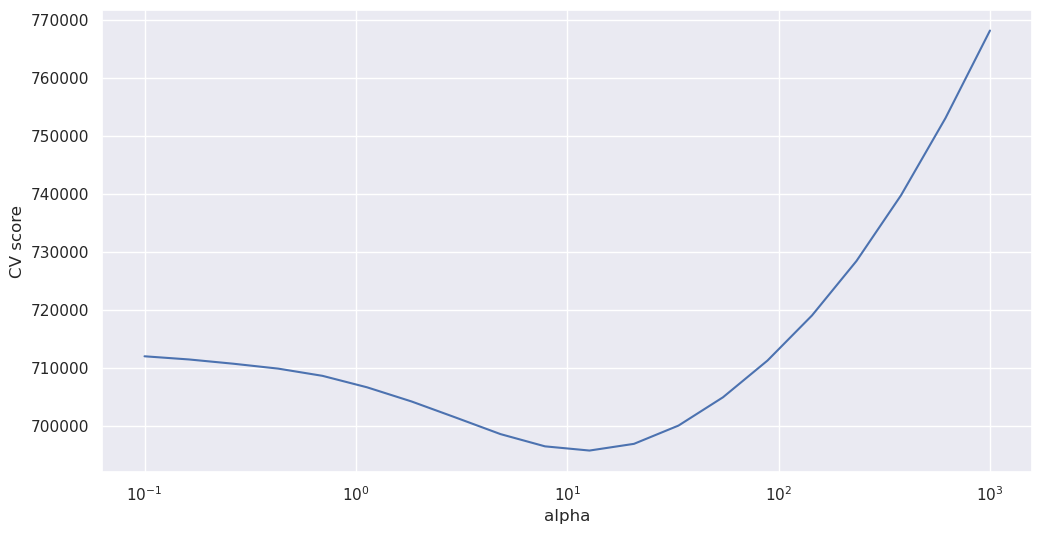

In [291]:
alphas = np.logspace(-1, 3, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [292]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

cv_scores = cross_val_score(pipeline, X_train, y_train.Speed_to_100, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.6f" % np.mean(-cv_scores))

pipeline.fit(X_train, y_train.Speed_to_100)
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
print("Train RMSE = %.6f" % mean_squared_error(y_train.Speed_to_100, y_train_pred, squared=False))
print("Test RMSE = %.6f" % mean_squared_error(y_test.Speed_to_100, y_pred, squared=False))

Cross validation scores:
	 -0.8435
	-0.8346
	-1.0037
	-0.9613
	-0.8850
	-0.8760
	-0.8246
	-0.8233
	-0.8454
	-0.8886
Mean CV RMSE = 0.878610
Train RMSE = 0.866817
Test RMSE = 1.662536
